# Scenario Analysis - "Grid modelling to assess electrofuels supply potential - The impact of electrofuels on the US electricity grid"

This notebook reports the results of preliminary runs for the scenarios defined in the table [here](https://docs.google.com/document/d/1ssc5ilxEhEYYjFDCo5cIAgP7zSRcO4uVUXjxbyfR88Q/edit?tab=t.0). In this notebook, a single scenario is analyzed. Another notebook is available for multi-scenario comparison.

**Scenarios Analyzed:**
- *Scenario 1: [Brief Description]*
- *Scenario 2: [Brief Description]*
- *Scenario 10: [Brief Description]*

---

## 1. Setup and Data Loading

*This section handles the initial setup, including importing necessary libraries and loading the solved PyPSA network data for each scenario.*

### 1.1. Import Libraries

In [1]:
!pip install plotly -qq

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pycountry

import pypsa
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
from pathlib import Path

import cartopy.crs as ccrs # For plotting maps
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import box
from matplotlib.offsetbox import AnnotationBbox, AuxTransformBox
from matplotlib.patches import Wedge
import matplotlib.path as mpath
import matplotlib.transforms as mtransforms
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerPatch
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import plotly.express as px
import plotly.graph_objects as go

from shapely.geometry import LineString
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import yaml

import warnings
warnings.filterwarnings("ignore")

from _helpers import (
    attach_grid_region_to_buses, attach_state_to_buses, compute_demand,
    compute_data_center_load, compute_carrier_costs, fill_missing_color,
    fill_missing_nice_names, update_ac_dc_bus_coordinates, assign_location,
    create_hydrogen_capacity_map, print_hydrogen_capacity_summary, create_ft_capacity_by_grid_region_map,
    create_ft_capacity_map, compute_h2_capacities, plot_h2_capacities_bar, calculate_dispatch, 
    plot_electricity_dispatch, compute_and_plot_load, calculate_lcoe_summary_and_map,
    plot_lcoe_map_by_grid_region, plot_h2_capacities_map, plot_lcoh_maps_by_grid_region,
    calculate_weighted_lcoh_table_by_year, calculate_total_generation_by_carrier,
    plot_hourly_hydrogen_dispatch_all
    )

/home/user/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
pd.set_option('display.width', None)    
pd.set_option('display.max_colwidth', None)

### 1.2. Load Solved Network(s)

Scenario 1 is used as default for the analysis. Please change the number in `scenario_dir` to analyze a different scenario. The base year results are common for all the scenarios.

In [4]:
# -----------------------------
# Project folder path
# -----------------------------
project_root = Path().resolve()

# -----------------------------
# Base year network path
# -----------------------------
base_year_file = project_root / "results" / "base_year" / "elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc"

networks = {
    "Base_2023": pypsa.Network(base_year_file)
}

# -----------------------------
# Scenario folder path (single scenario)
# -----------------------------
scenario_dir = project_root / "results" / "scenarios" / "scenario_01" #change the number to choose the scenario of your interest

## Folder structure
#  project_root/
#  └── notebooks/
#       ├── scenario_analysis.ipynb
#       └── results/
#            ├── base_year/
#            │   ├── elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc
#            └── scenarios/
#                 ├── scenario_01/
#                 │   ├── elec_s_100_ec_lcopt_3H_3H_2030_0.071_AB_10export.nc
#                 │   ├── elec_s_100_ec_lcopt_3H_3H_2035_0.071_AB_10export.nc
#                 │   └── elec_s_100_ec_lcopt_3H_3H_2040_0.071_AB_10export.nc
#                 ├── scenario_02/
#                 ├── ...
#                 ├── scenario_10/

years = [2030, 2035, 2040]

# -----------------------------
# Upload available networks per year
# -----------------------------
for year in years:
    file_name = f"elec_s_100_ec_lcopt_3H_3H_{year}_0.071_AB_10export.nc"
    file_path = scenario_dir / file_name

    if file_path.exists():
        scenario_name = scenario_dir.name  # e.g., "scenario_01"
        key = f"{scenario_name}_{year}"
        networks[key] = pypsa.Network(file_path)
        print(f"Loaded: {key}")
    else:
        print(f"Missing: {file_path.relative_to(project_root)}")

network_names = list(networks.keys())
print("\n Uploaded networks:")
print(list(networks.keys()))

INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_3H_3H_2030_0.071_AB_10export.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


Loaded: scenario_01_2030


INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_3H_3H_2035_0.071_AB_10export.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


Loaded: scenario_01_2035


INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_3H_3H_2040_0.071_AB_10export.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


Loaded: scenario_01_2040

 Uploaded networks:
['Base_2023', 'scenario_01_2030', 'scenario_01_2035', 'scenario_01_2040']


In [5]:
grid_region_shapes_path = project_root / "needs_grid_regions_aggregated.geojson"
state_shapes_path = project_root / "gadm41_USA_1.json"

regions_onshore = gpd.read_file(grid_region_shapes_path)

In [6]:
with open('plotting.yaml', 'r') as file:
    plotting = yaml.safe_load(file)

tech_colors = plotting['tech_colors']
nice_names = plotting['nice_names']
rename_techs = plotting['rename_tech']
rename_tech_colors = plotting['renamed_tech_colors']

In [7]:
for network in networks.keys():
    attach_grid_region_to_buses(networks[network], grid_region_shapes_path)
    attach_state_to_buses(networks[network], state_shapes_path)

---

## 2. Input Data Analysis & Validation

*Before diving into results, we validate and visualize the key input data that drives the model. This primarily focuses on electricity demand.*

### 2.1. Demand Projections & Overview
*A summary of the overall demand assumptions for the model years.*

In [8]:
# Code to extract and display demand assumptions
# e.g., total annual TWh demand per country
pass

### 2.2. Country-wise Total Electricity Demand (Time Series)
*This plot shows the electricity demand profile over the year for each country, which is a primary driver for the system's operation.*

In [9]:
networks.keys()

dict_keys(['Base_2023', 'scenario_01_2030', 'scenario_01_2035', 'scenario_01_2040'])

In [10]:
import pandas as pd

# Industrial processes consuming AC electricity
target_processes = [
    "SMR CC", "Haber-Bosch", "ethanol from starch", "ethanol from starch CC",
    "DRI", "DRI CC", "DRI H2", "BF-BOF", "BF-BOF CC", "EAF",
    "dry clinker", "cement finishing", "dry clinker CC"
]

# Static and dynamic loads
static_load_carriers = ["rail transport electricity", "agriculture electricity", "industry electricity"]
dynamic_load_carriers = ["AC", "services electricity", "land transport EV", "data center"]

demand = pd.DataFrame(columns=networks.keys(),
                      index=dynamic_load_carriers + static_load_carriers + ["total demand"])
demand.index.name = "Load type (TWh)"

for name, n in networks.items():
    nhours = n.snapshot_weightings.objective.sum()

    # 1. Static loads
    static_totals = (
        n.loads.groupby("carrier").sum().p_set
        .reindex(static_load_carriers)
        .fillna(0)
    )
    static_load_twh = static_totals.sum() * nhours / 1e6

    # 2. Industrial AC
    process_links = n.links[n.links.carrier.isin(target_processes)]
    ac_input_links = process_links[process_links.bus0.map(n.buses.carrier) == "AC"].index
    ind_ac_profile = n.links_t.p0[ac_input_links].sum(axis=1)
    ind_ac_twh = (ind_ac_profile * n.snapshot_weightings.objective).sum() / 1e6

    # 3. Non-industrial AC
    ac_loads = n.loads[n.loads.carrier == "AC"]
    industrial_ac_buses = n.links.loc[ac_input_links, "bus0"].unique()
    ac_non_ind_idx = ac_loads[~ac_loads.bus.isin(industrial_ac_buses)].index
    ac_profile = n.loads_t.p_set[ac_non_ind_idx.intersection(n.loads_t.p_set.columns)].sum(axis=1)
    ac_twh = (ac_profile * n.snapshot_weightings.objective).sum() / 1e6 - ind_ac_twh

    # 4. Services and EVs
    serv_idx = [i for i in n.loads[n.loads.carrier == "services electricity"].index
                if i in n.loads_t.p_set.columns]
    ev_idx = [i for i in n.loads[n.loads.carrier == "land transport EV"].index
              if i in n.loads_t.p_set.columns]
    serv_profile = n.loads_t.p_set[serv_idx].sum(axis=1) if serv_idx else 0
    ev_profile = n.loads_t.p_set[ev_idx].sum(axis=1) if ev_idx else 0
    serv_twh = (serv_profile * n.snapshot_weightings.objective).sum() / 1e6
    ev_twh = (ev_profile * n.snapshot_weightings.objective).sum() / 1e6

    # 5. Data centers
    data_center_p_set_sum = n.loads.loc[n.loads.carrier == "data center", "p_set"].sum()
    data_center_twh = data_center_p_set_sum * nhours / 1e6

    # 6. Other electricity (included in industrial consumption)
    other_idx = [i for i in n.loads[n.loads.carrier == "other electricity"].index
                 if i in n.loads_t.p_set.columns]
    other_profile = n.loads_t.p_set[other_idx].sum(axis=1) if other_idx else 0
    other_twh = (other_profile * n.snapshot_weightings.objective).sum() / 1e6

    industry_static_twh = static_totals.get("industry electricity", 0) * nhours / 1e6
    industry_elec_twh = industry_static_twh + ind_ac_twh + other_twh

    demand.loc["rail transport electricity", name] = static_totals.get("rail transport electricity", 0) * nhours / 1e6
    demand.loc["agriculture electricity", name] = static_totals.get("agriculture electricity", 0) * nhours / 1e6
    demand.loc["industry electricity", name] = industry_elec_twh
    demand.loc["AC", name] = ac_twh
    demand.loc["services electricity", name] = serv_twh
    demand.loc["land transport EV", name] = ev_twh
    demand.loc["data center", name] = data_center_twh
    demand.loc["total demand", name] = (
        static_load_twh + ac_twh + ind_ac_twh + serv_twh + ev_twh + data_center_twh + other_twh
    )
    demand.loc["total demand no data center", name] = (
        static_load_twh + ac_twh + ind_ac_twh + serv_twh + ev_twh + other_twh
    )


In [11]:
# === 1. NREL reference values (2023, 2030, 2040) ===
nrel_data = {
    "AC (residential + some industrial processes)": [1360.81, 1359.91, 1392.19],
    "services electricity": [1381.11, 1398.69, 1579.71],
    "land transport EV":    [13.10,   73.95,   59.70],
    "rail transport electricity": [7.29, 7.64, 8.29],
    "agriculture electricity": [0, 0, 0],
    "industry electricity": [1036.81, 1109.69, 1213.94],
    "total demand (incl. data centers)": [3799.12, 4293.30, 5072.86],
    "total demand (excl. data centers)": [3799.12, 4293.30, 5072.86],
}

# === 2. Mapping PyPSA names → NREL names ===
row_rename_map = {
    "AC": "AC (residential + some industrial processes)",
    "total demand": "total demand (incl. data centers)",
    "total demand no data center": "total demand (excl. data centers)"
}

# === 3. Extract years from network names ===
network_years = {}
for key in networks:
    match = re.search(r'(\d{4})', key)
    if match:
        network_years[int(match.group(1))] = key

rows = list(nrel_data.keys())
columns = pd.MultiIndex.from_product(
    [sorted(network_years.keys()), ["PyPSA", "NREL", "diff %"]]
)
comparison_df = pd.DataFrame(index=rows, columns=columns)

for year, net_key in network_years.items():
    for row in rows:
        pypsa_row = {v: k for k, v in row_rename_map.items()}.get(row, row)
        
        pypsa_val = demand.at[pypsa_row, net_key] if pypsa_row in demand.index else np.nan
        nrel_vals = nrel_data.get(row, None)

        if nrel_vals and year in [2023, 2030, 2040]:
            col_idx = [2023, 2030, 2040].index(year)
            nrel_val = nrel_vals[col_idx]
        else:
            nrel_val = np.nan

        comparison_df.at[row, (year, "PyPSA")] = pypsa_val
        comparison_df.at[row, (year, "NREL")] = nrel_val

        if pd.notna(pypsa_val) and pd.notna(nrel_val) and nrel_val != 0:
            diff = 100 * (pypsa_val - nrel_val) / nrel_val
        else:
            diff = np.nan
        comparison_df.at[row, (year, "diff %")] = diff

def highlight_diff(val):
    if pd.isna(val):
        return ''
    if val > 10:
        return 'background-color: #ffcccc'  # rosso chiaro
    elif val < -10:
        return 'background-color: #cce5ff'  # azzurro chiaro
    else:
        return 'background-color: #d4edda'  # verde chiaro

styled = comparison_df.style
for year in network_years:
    styled = styled.applymap(highlight_diff, subset=pd.IndexSlice[:, (year, "diff %")])
styled = styled.format(na_rep="N/A", precision=2)

display(styled)


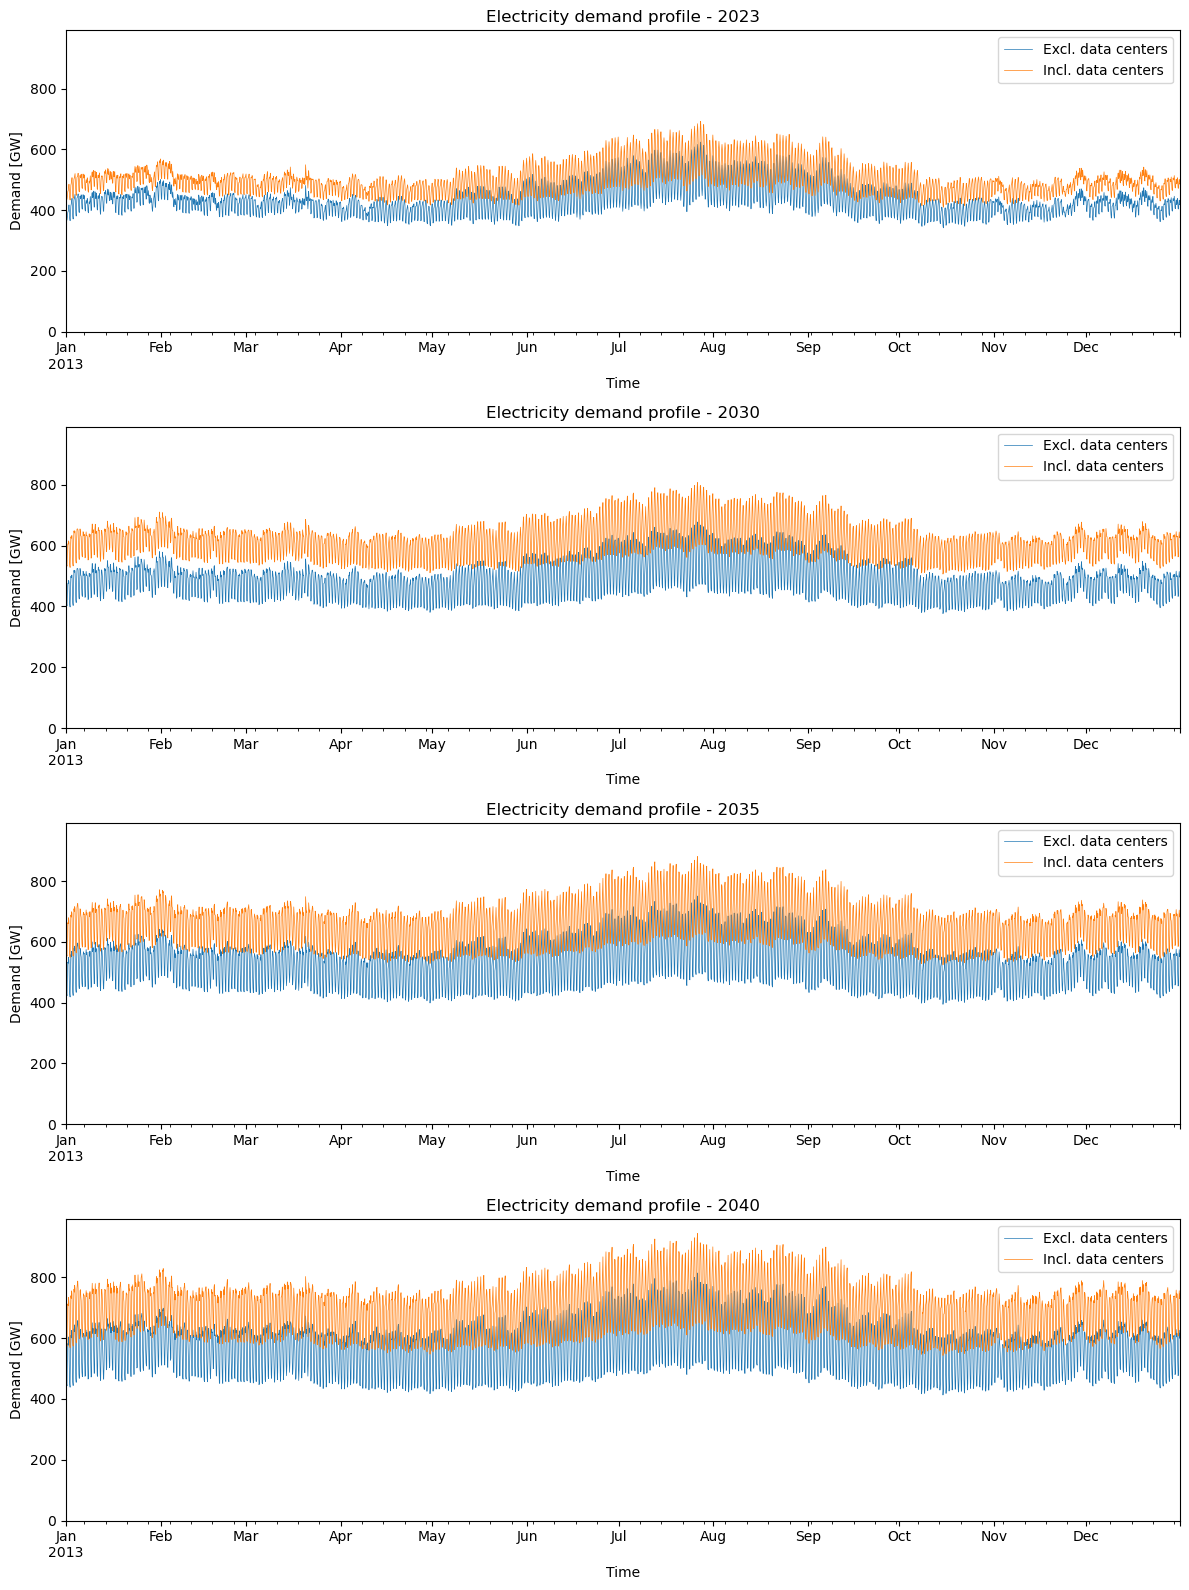

In [12]:
# === 1. Extract years from network names ===
years = {}
for name in networks:
    match = re.search(r"\d{4}", name)
    if match:
        years[int(match.group())] = name
years = dict(sorted(years.items()))  # sort by year

# === 2. Compute y-axis max (in GW) and build demand profiles ===
y_max = 0
demand_profiles_incl = {}
demand_profiles_excl = {}

for year, name in years.items():
    n = networks[name]
    nhours = n.snapshot_weightings.objective.sum()

    # Dynamic loads: AC, services, EV, other electricity
    dynamic_loads = n.loads[n.loads.carrier.isin(["AC", "services electricity", "land transport EV", "other electricity"])]
    dynamic_idx = dynamic_loads.index.intersection(n.loads_t.p_set.columns)
    dyn_profile = n.loads_t.p_set[dynamic_idx].sum(axis=1)

    # Static loads: rail, agriculture, industry
    static_carriers = ["rail transport electricity", "agriculture electricity", "industry electricity"]
    static_load = n.loads[n.loads.carrier.isin(static_carriers)]
    static_sum = static_load.groupby("carrier").sum()["p_set"].sum()  # MW
    static_profile = pd.Series(static_sum, index=n.snapshots)

    # Data centers (flat profile if present)
    if "data center" in n.loads.carrier.values:
        dc_sum = n.loads[n.loads.carrier == "data center"]["p_set"].sum()
        dc_profile = pd.Series(dc_sum, index=n.snapshots)
    else:
        dc_profile = 0

    # Total profiles (in GW)
    profile_excl = (dyn_profile + static_profile) / 1000
    profile_incl = (dyn_profile + static_profile + dc_profile) / 1000

    demand_profiles_excl[year] = profile_excl
    demand_profiles_incl[year] = profile_incl

    y_max = max(y_max, profile_incl.max())

y_max *= 1.05  # add 5% margin

# === 3. Plot profiles for each year ===
fig, axes = plt.subplots(nrows=len(years), figsize=(12, 4 * len(years)), sharey=True)

if len(years) == 1:
    axes = [axes]  # ensure list if only one subplot

for ax, (year, name) in zip(axes, years.items()):
    demand_profiles_excl[year].plot(ax=ax, linewidth=0.5, color="tab:blue", label="Excl. data centers")
    demand_profiles_incl[year].plot(ax=ax, linewidth=0.5, color="tab:orange", label="Incl. data centers")

    ax.set_title(f"Electricity demand profile - {year}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Demand [GW]")
    ax.set_ylim(0, y_max)
    ax.legend(loc="upper right")

plt.tight_layout()
plt.show()


### 2.3. State-wise Total Electricity Demand (Validation Year)
*A bar plot showing the total annual electricity demand for each state or region for the validation year. This helps confirm the spatial distribution of demand.*

In [13]:
base_demand_grid_region, base_demand_state = compute_demand(networks["Base_2023"])

In [14]:
base_demand_grid_region.T

region                      Alaska  California  Delta  Florida  Hawaii  \
carrier                                                                  
AC                            1.26      102.02  57.89    80.28    3.56   
agriculture electricity       0.05        5.29   1.59     2.89    0.16   
industry electricity          0.94       66.54  38.79    23.17    2.46   
land transport EV             0.06        6.34   1.86     3.32    0.19   
rail transport electricity    0.00        0.52   0.16     0.28    0.02   
services electricity          1.14       92.81  52.68    73.04    3.24   

region                      Mid-Atlantic  Midwest  Mountain  New England  \
carrier                                                                    
AC                                298.50   178.02     39.76        32.26   
agriculture electricity             9.23     7.64      2.94         2.00   
industry electricity              135.94    96.52     31.38        29.72   
land transport EV                  11.27     9.53      3.65         2.49   
rail transport electricity          0.89     0.75      0.30         0.20   
services electricity              271.56   161.99     36.18        29.36   

region                      New York  Northwest  Plains  Southeast  Southwest  \
carrier                                                                         
AC                             73.75      76.83  110.49     206.30      58.97   
agriculture electricity         4.63       2.50    4.91       7.05       2.70   
industry electricity           75.22      26.61   57.86      65.37      21.24   
land transport EV               5.75       3.10    6.07       8.33       3.24   
rail transport electricity      0.45       0.24    0.48       0.70       0.27   
services electricity           67.11      69.89  100.52     187.68      53.65   

region                       Texas  
carrier                             
AC                          151.80  
agriculture electricity       3.78  
industry electricity         60.67  
land transport EV             4.40  
rail transport electricity    0.37  
services electricity        138.11

In [15]:
base_demand_state.T

region                        AK     AL    AR     AZ      CA     CO     DE  \
carrier                                                                      
AC                          1.26  25.09  9.56  30.75  107.06  17.52  22.48   
agriculture electricity     0.05   0.74  0.22   1.36    6.81   0.78   1.41   
industry electricity        0.94   9.79  2.38   9.42   81.83   8.16  28.04   
land transport EV           0.06   0.86  0.26   1.62    8.21   0.99   1.71   
rail transport electricity  0.00   0.08  0.02   0.14    0.67   0.08   0.14   
services electricity        1.14  22.82  8.70  27.98   97.40  15.94  20.45   

region                         FL     GA    HI     IA     ID     IL     IN  \
carrier                                                                      
AC                          80.28  57.46  3.56  20.97  16.93  49.75  30.22   
agriculture electricity      2.89   2.28  0.16   0.82   1.04   1.73   1.15   
industry electricity        23.17  18.17  2.46   9.93   8.34  27.13  13.41   
land transport EV            3.32   2.66  0.19   1.02   1.29   2.13   1.42   
rail transport electricity   0.28   0.22  0.02   0.08   0.10   0.17   0.11   
services electricity        73.04  52.27  3.24  19.09  15.41  45.26  27.50   

region                         KS     KY     LA     MA     MD    ME     MI  \
carrier                                                                      
AC                          22.58  41.56  36.86  28.45  36.28  3.81  31.19   
agriculture electricity      1.83   1.49   1.09   1.71   1.17  0.29   1.18   
industry electricity        21.59  20.50  33.07  25.90  17.93  3.75  15.78   
land transport EV            2.36   1.82   1.27   2.11   1.43  0.37   1.48   
rail transport electricity   0.17   0.15   0.11   0.17   0.11  0.03   0.12   
services electricity        20.54  37.81  33.54  25.89  33.01  3.47  28.37   

region                         MN     MO     MS    MT     NC    ND    NE  \
carrier                                                                    
AC                          25.94  30.91  11.47  4.57  48.00  9.16  9.54   
agriculture electricity      1.11   1.04   0.28  0.17   1.33  0.14  0.33   
industry electricity        15.61  11.89   3.34  2.65  11.22  2.26  3.92   
land transport EV            1.41   1.26   0.33  0.21   1.59  0.18  0.42   
rail transport electricity   0.11   0.10   0.03  0.02   0.13  0.02  0.03   
services electricity        23.60  28.13  10.44  4.15  43.67  8.33  8.68   

region                        NH     NM     NV     NY     OH     OK     OR  \
carrier                                                                      
AC                          0.00  18.01  15.94  73.75  43.82  27.35  23.69   
agriculture electricity     0.00   1.05   0.92   4.63   1.59   0.59   0.36   
industry electricity        0.07   9.93   7.53  75.22  20.20  10.04   3.53   
land transport EV           0.01   1.25   1.11   5.75   1.94   0.71   0.45   
rail transport electricity  0.00   0.10   0.09   0.45   0.15   0.06   0.03   
services electricity        0.00  16.39  14.50  67.11  39.86  24.88  21.55   

region                         PA     SC    SD     TN      TX     UT     VA  \
carrier                                                                       
AC                          39.34  28.83  3.07  46.92  173.36  11.19  93.34   
agriculture electricity      2.08   1.10  0.19   1.60    4.57   0.38   1.28   
industry electricity        27.13   9.24  2.18  16.95   68.87   3.44  15.18   
land transport EV            2.56   1.31  0.23   1.91    5.34   0.47   1.54   
rail transport electricity   0.20   0.11  0.02   0.16    0.45   0.04   0.12   
services electricity        35.79  26.23  2.79  42.69  157.72  10.18  84.92   

region                         WA     WI    WY  
carrier                                         
AC                          32.30  23.72  3.85  
agriculture electricity      1.01   1.35  0.06  
industry electricity        13.92  15.17  1.25  
land transpor

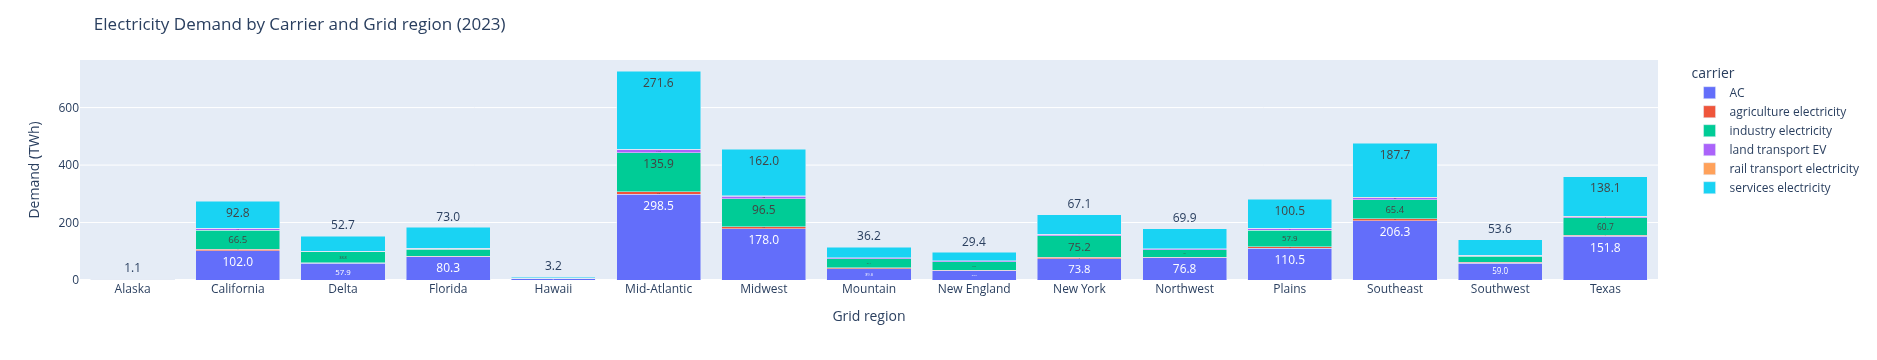

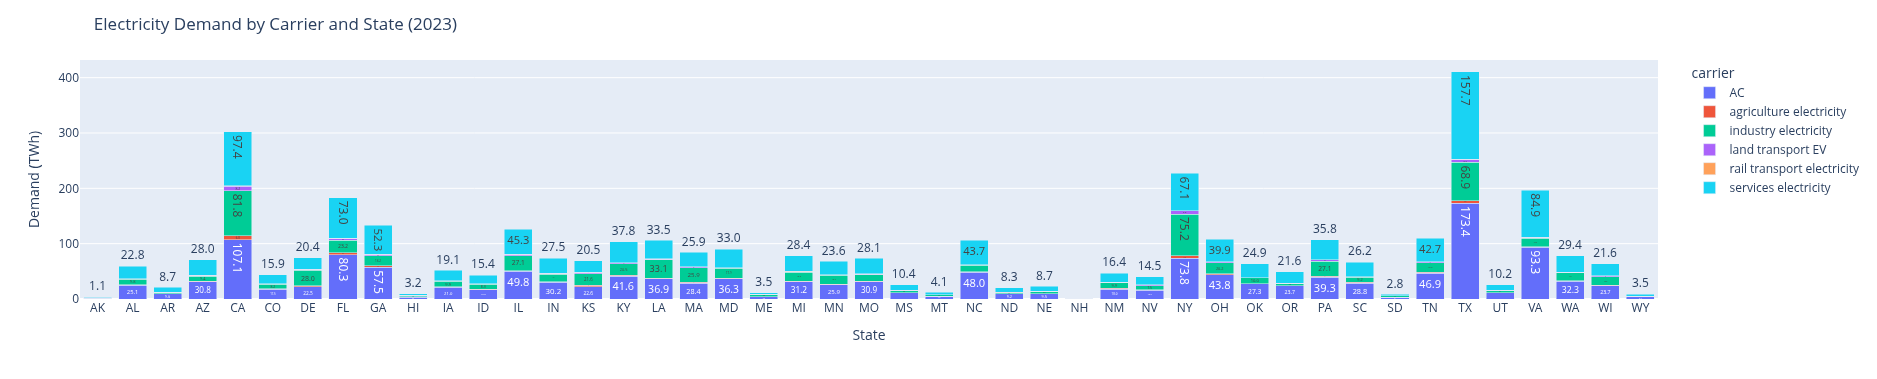

In [16]:
fig1 = px.bar(base_demand_grid_region, barmode='stack', text_auto='.1f')
fig1.update_layout(width=1100, yaxis_title='Demand (TWh)', xaxis_title='Grid region', title='Electricity Demand by Carrier and Grid region (2023)')
fig1.show()

fig1 = px.bar(base_demand_state, barmode='stack', text_auto='.1f')
fig1.update_layout(width=3000, yaxis_title='Demand (TWh)', xaxis_title='State', title='Electricity Demand by Carrier and State (2023)')
fig1.show()

### 2.4. Data Center Loads/Demands
*Isolating and visualizing the specific demand profile of data centers to understand their impact on the system.*

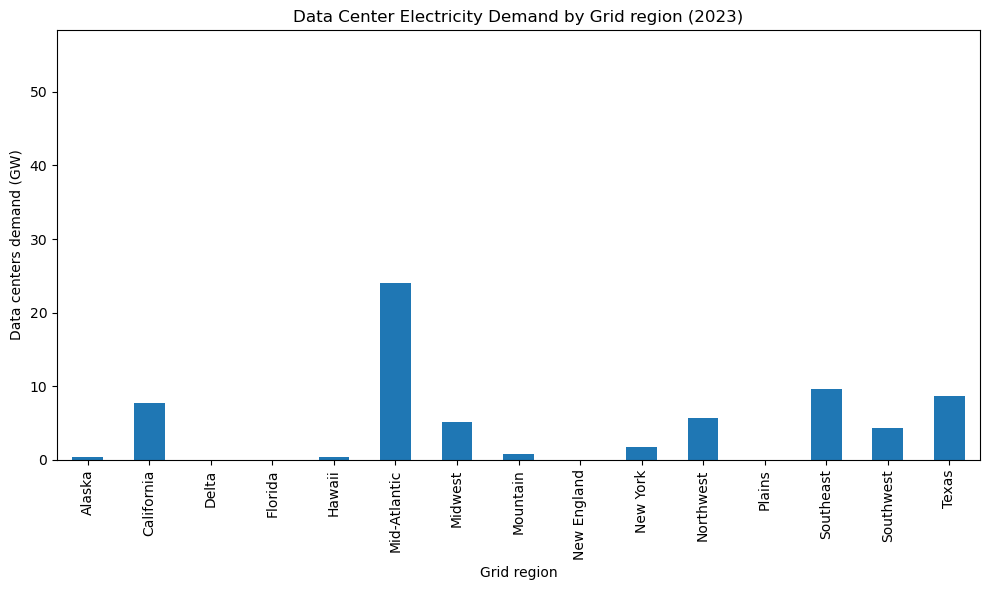

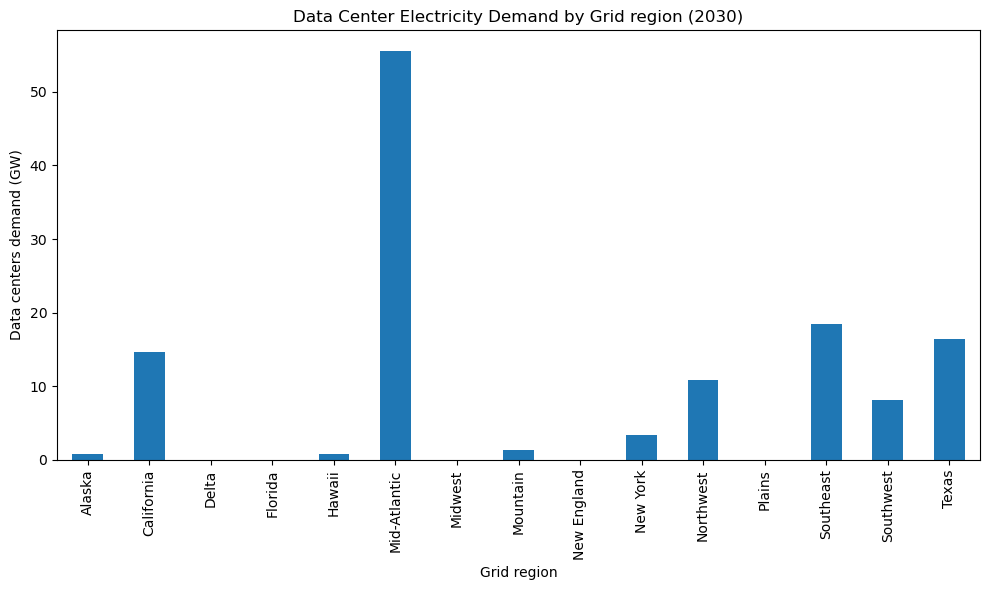

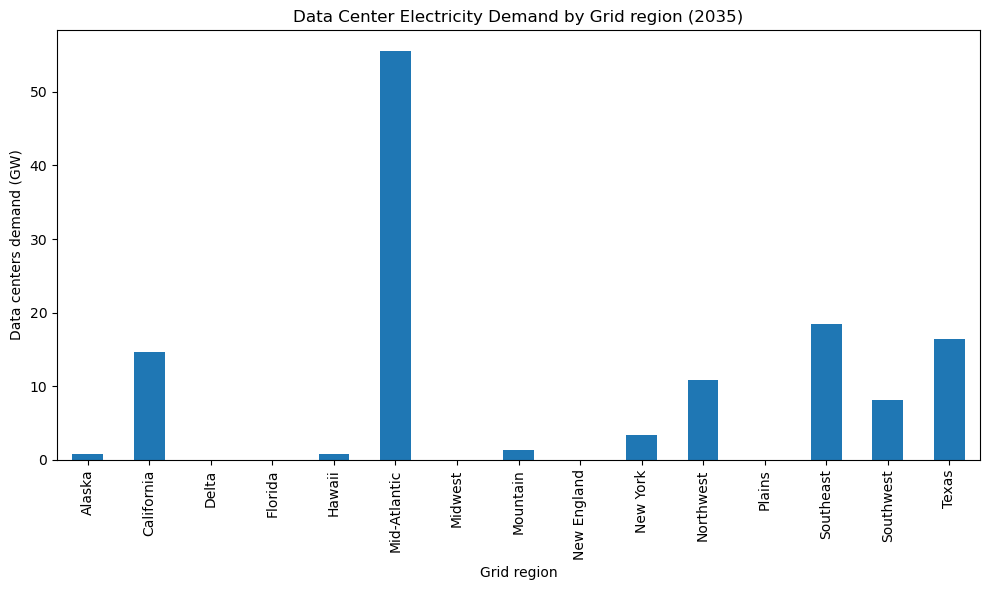

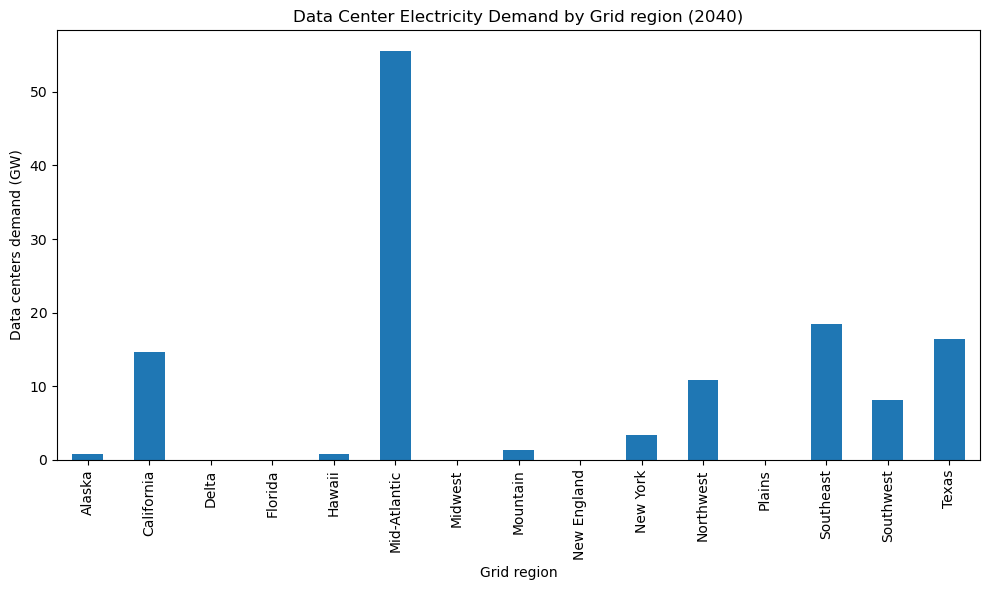

In [17]:
data_center_load = {}
for key, net in networks.items():
    data_center_load[key] = compute_data_center_load(net)

max_val = 0
for df in data_center_load.values():
    demand_by_grid_region = df.groupby("grid_region")["p_set"].sum().div(1e3)
    max_val = max(max_val, demand_by_grid_region.max())

for key, df in data_center_load.items():
    demand_by_grid_region = df.groupby("grid_region")["p_set"].sum().div(1e3)

    # Extract year from key assuming format like "scenario_01_2030"
    year_match = re.search(r"\d{4}", key)
    year = year_match.group() if year_match else "Unknown Year"
    
    ax = demand_by_grid_region.plot(
        kind="bar",
        title=f"Data Center Electricity Demand by Grid region ({year})",
        ylabel="Data centers demand (GW)",
        xlabel="Grid region",
        figsize=(10, 6),
        legend=False
    )
    ax.set_ylim(0, max_val * 1.05)
    plt.tight_layout()
    plt.show()


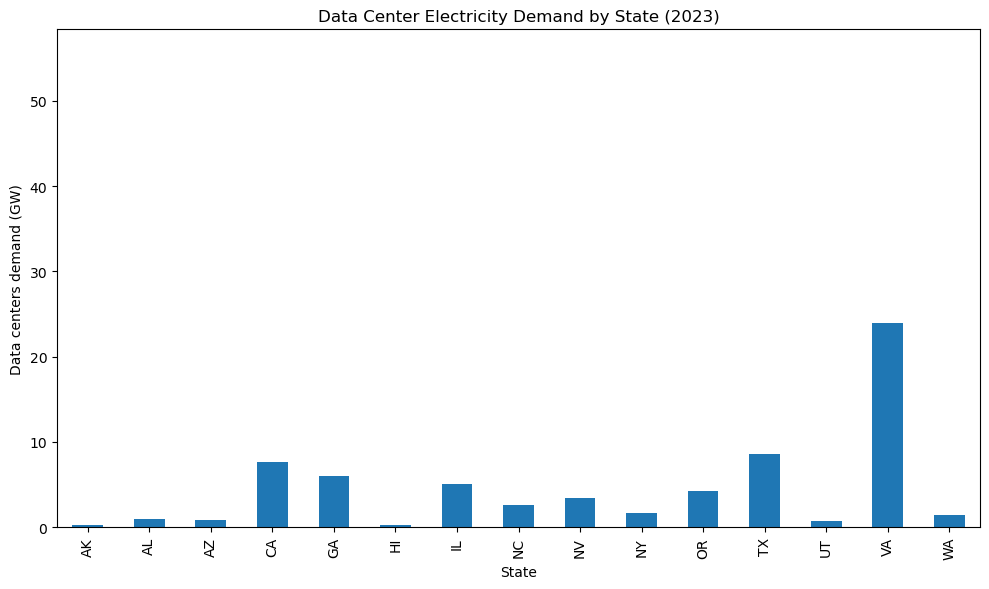

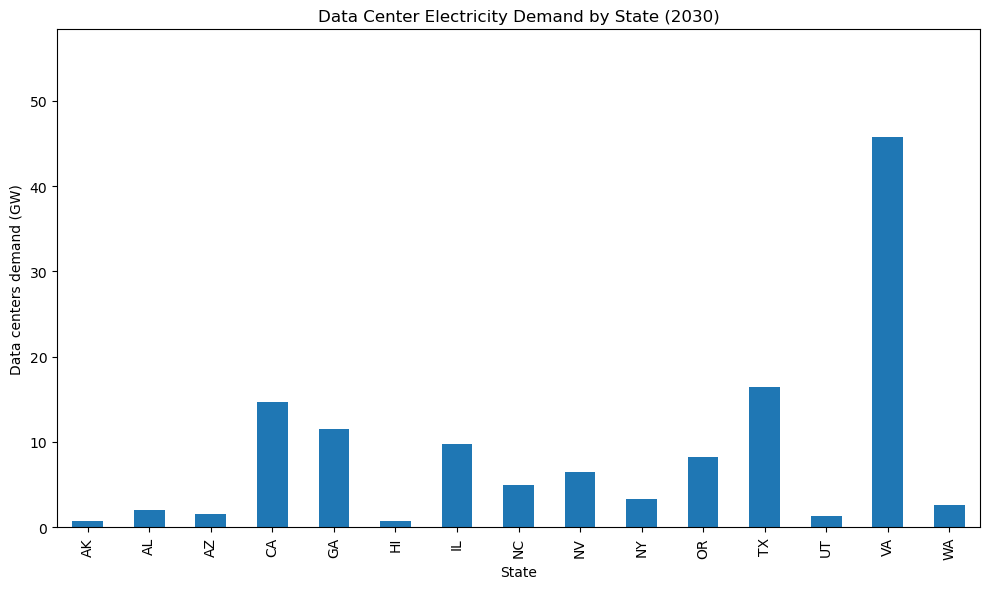

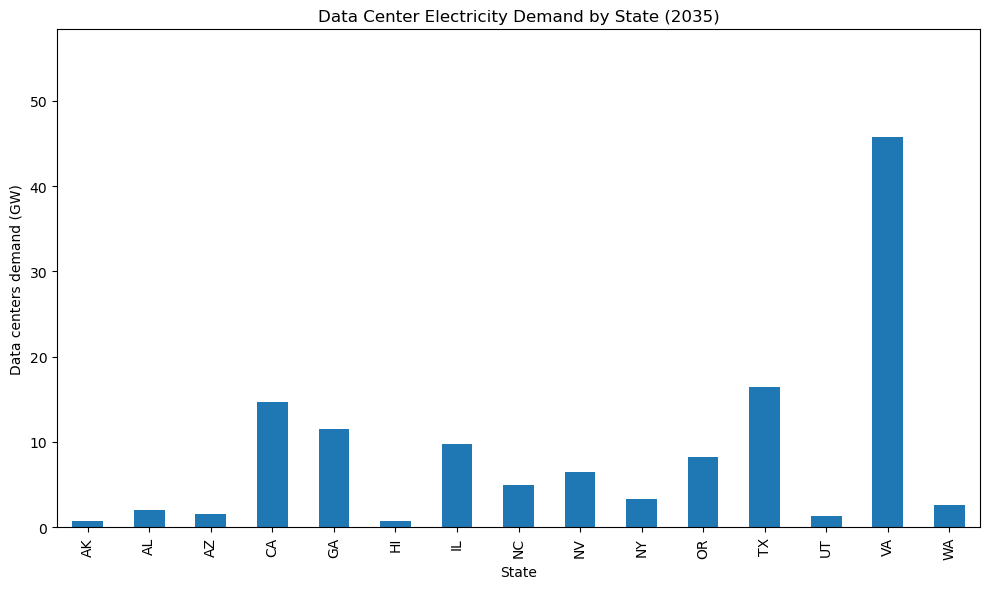

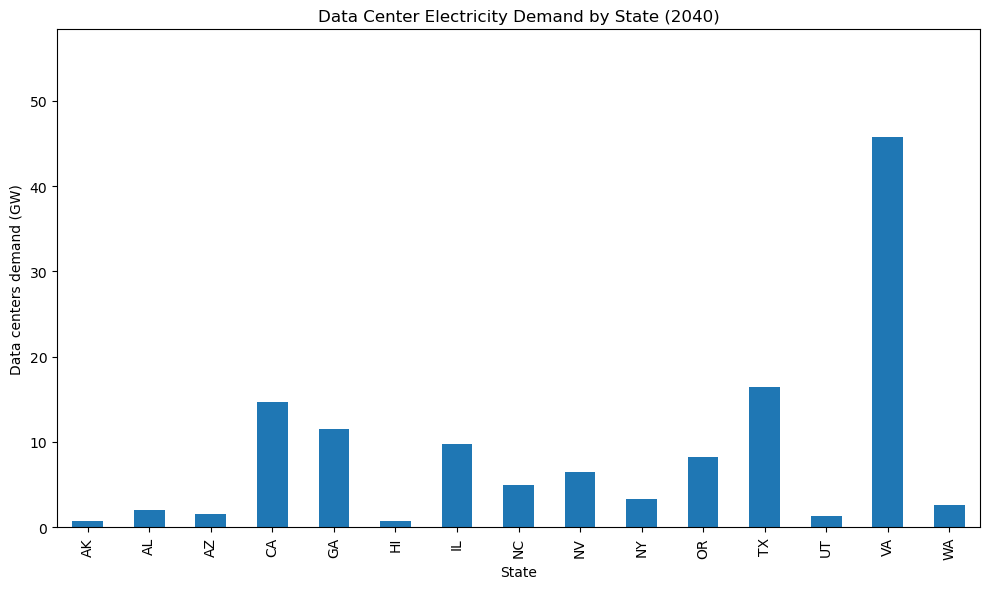

In [18]:
for key, df in data_center_load.items():
    demand_by_state = df.groupby("state")["p_set"].sum().div(1e3)
    demand_by_state = demand_by_state[demand_by_state > 0]

    if demand_by_state.empty:
        print(f"No demand data for {key}")
        continue

    # Extract year from key assuming format like "scenario_01_2030"
    year_match = re.search(r"\d{4}", key)
    year = year_match.group() if year_match else "Unknown Year"

    ax = demand_by_state.plot(
        kind="bar",
        title=f"Data Center Electricity Demand by State ({year})",
        ylabel="Data centers demand (GW)",
        xlabel="State",
        figsize=(10, 6),
        legend=False
    )
    ax.set_ylim(0, max_val * 1.05)
    plt.tight_layout()
    plt.show()

## 3. High-Level Results: System Cost

*This section presents the primary objective function result: the total annualized system cost.*

### 3.1. Total System Cost per Scenario
*A comparison of the total system cost across all analyzed scenarios. This is the key metric for overall economic performance.*

In [19]:
for idx, network in enumerate(networks.keys()):
    carrier_costs = compute_carrier_costs(networks[network], rename_techs).rename(columns={"cost": network_names[idx]}) / 1e9
    if idx == 0:
        total_carrier_costs = carrier_costs
    else:
        total_carrier_costs = total_carrier_costs.join(carrier_costs, how='outer', rsuffix=f'_{idx}')

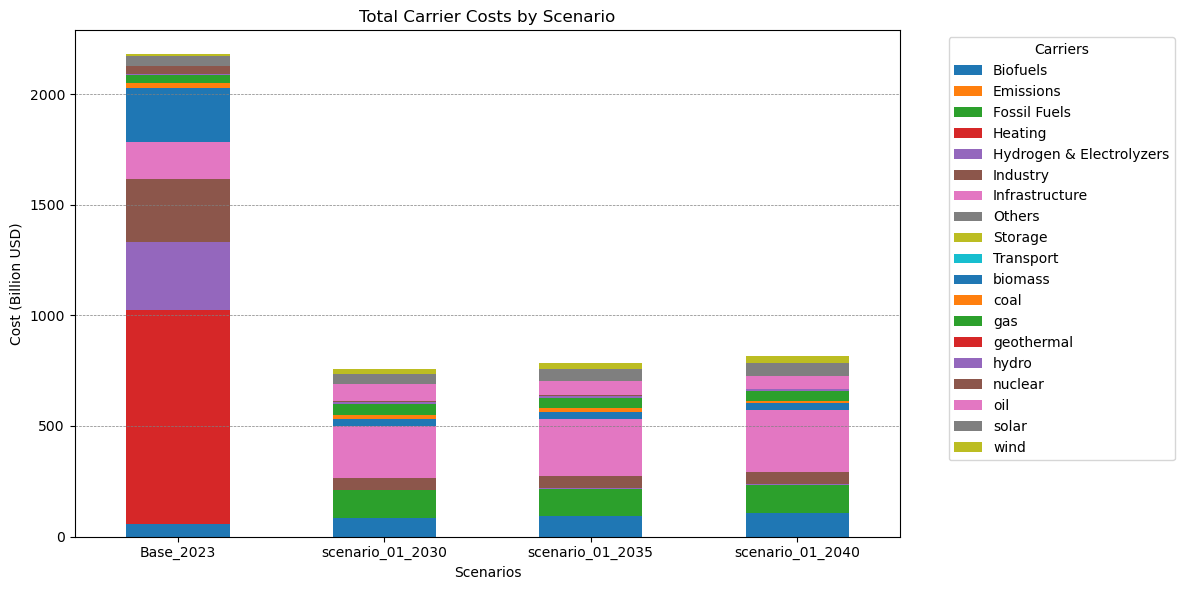

In [20]:
total_carrier_costs.T.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Total Carrier Costs by Scenario")
plt.ylabel("Cost (Billion USD)")
plt.xlabel("Scenarios")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')
plt.legend(title="Carriers", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

---

## 4. Capacity Analysis: What Was Built?

*Here, we analyze the optimal installed capacities of generation, storage, and conversion technologies as determined by the model.*

### 4.1. Map: Total Installed Electricity Capacity
*A map showing the total installed capacity (in GW) for each electricity generation carrier (e.g., Solar, Onshore Wind, Offshore Wind) at different locations.*

In [21]:
regions_onshore = gpd.read_file(grid_region_shapes_path)

# Prepare Data for Plotting
gen_p_nom_opt = n.generators.groupby(["bus", "carrier"]).p_nom_opt.sum()
sto_p_nom_opt = n.storage_units.groupby(["bus", "carrier"]).p_nom_opt.sum()
bus_carrier_capacity = pd.concat([gen_p_nom_opt, sto_p_nom_opt])
bus_carrier_capacity = bus_carrier_capacity[bus_carrier_capacity > 0]

line_values = n.lines.s_nom
links_values = n.links[n.links.carrier == "DC"].p_nom

n = update_ac_dc_bus_coordinates(n)

# Find carriers that need a color
carriers_to_plot = bus_carrier_capacity.index.get_level_values(1).unique()
for carrier in carriers_to_plot:
    if carrier not in n.carriers.index:
        n.add("Carrier", carrier)

for idx in tech_colors.keys():
    n.carriers.loc[idx, "color"] = tech_colors[idx]
    
fill_missing_nice_names(n, nice_names)

# Assign colors from the dictionary, using 'gray' for any not found
n.carriers["color"] = n.carriers.index.map(tech_colors)
n.carriers.color.fillna("gray", inplace=True)

Plotting network: Base_2023


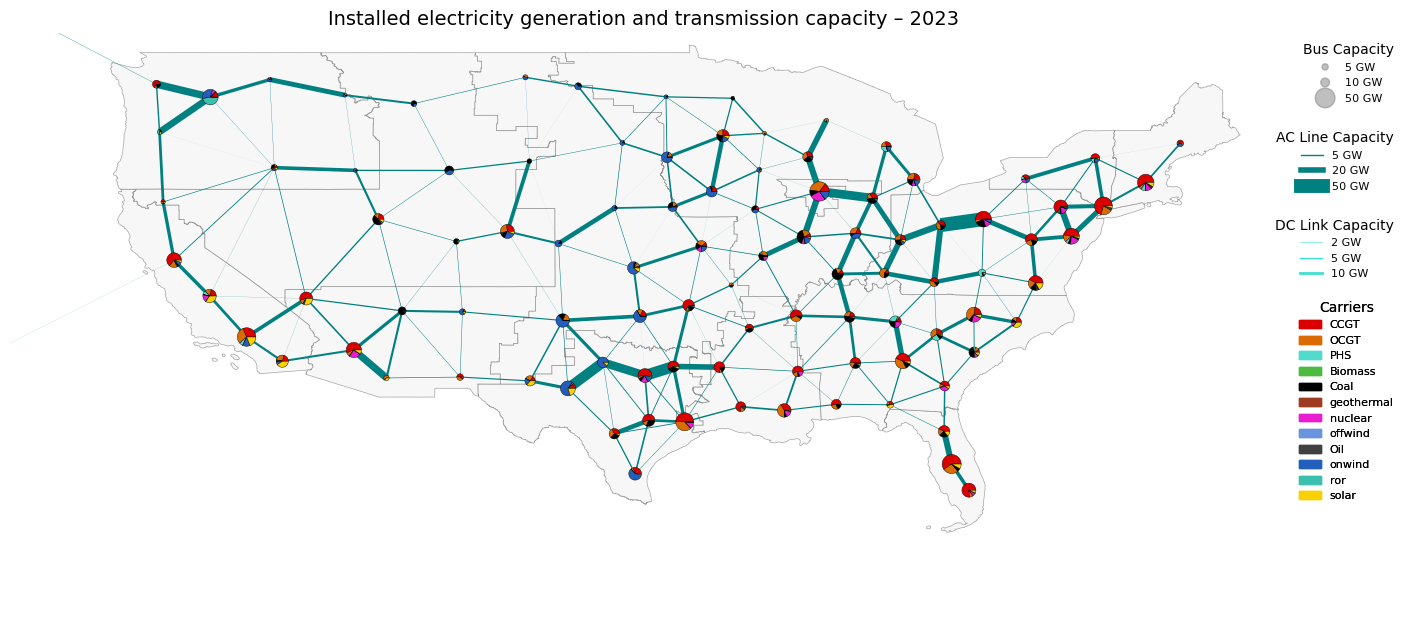

Plotting network: scenario_01_2030


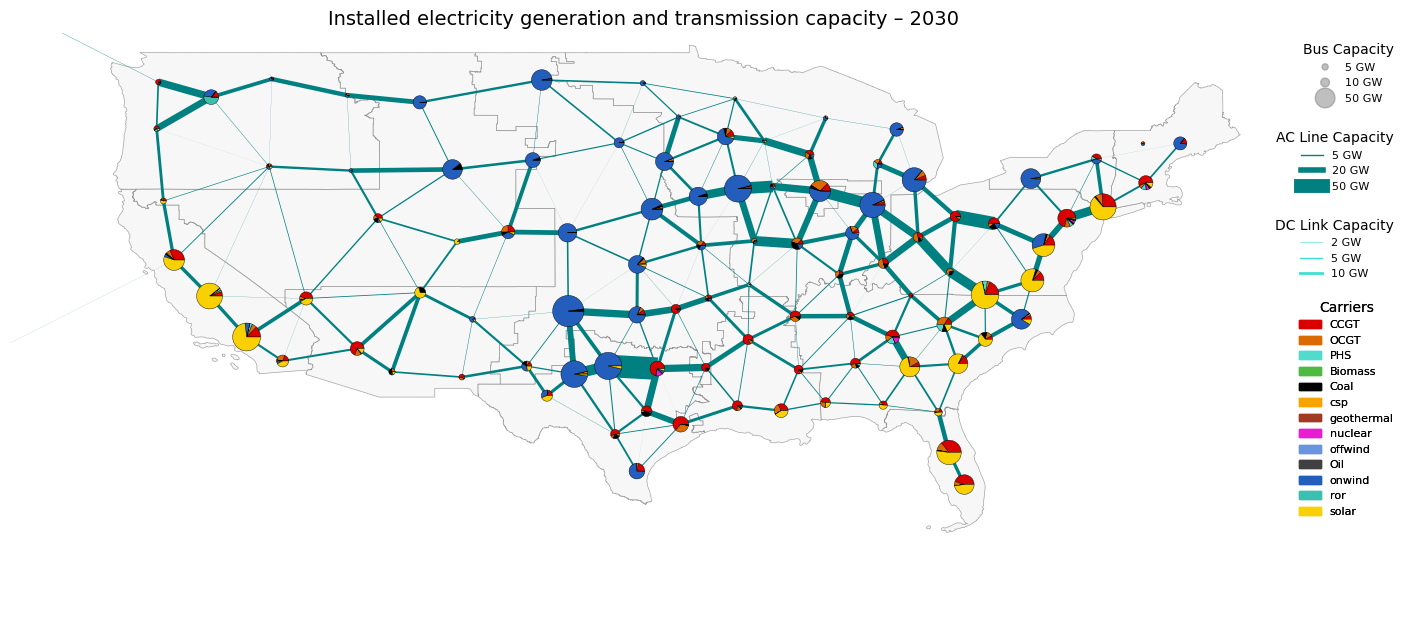

Plotting network: scenario_01_2035


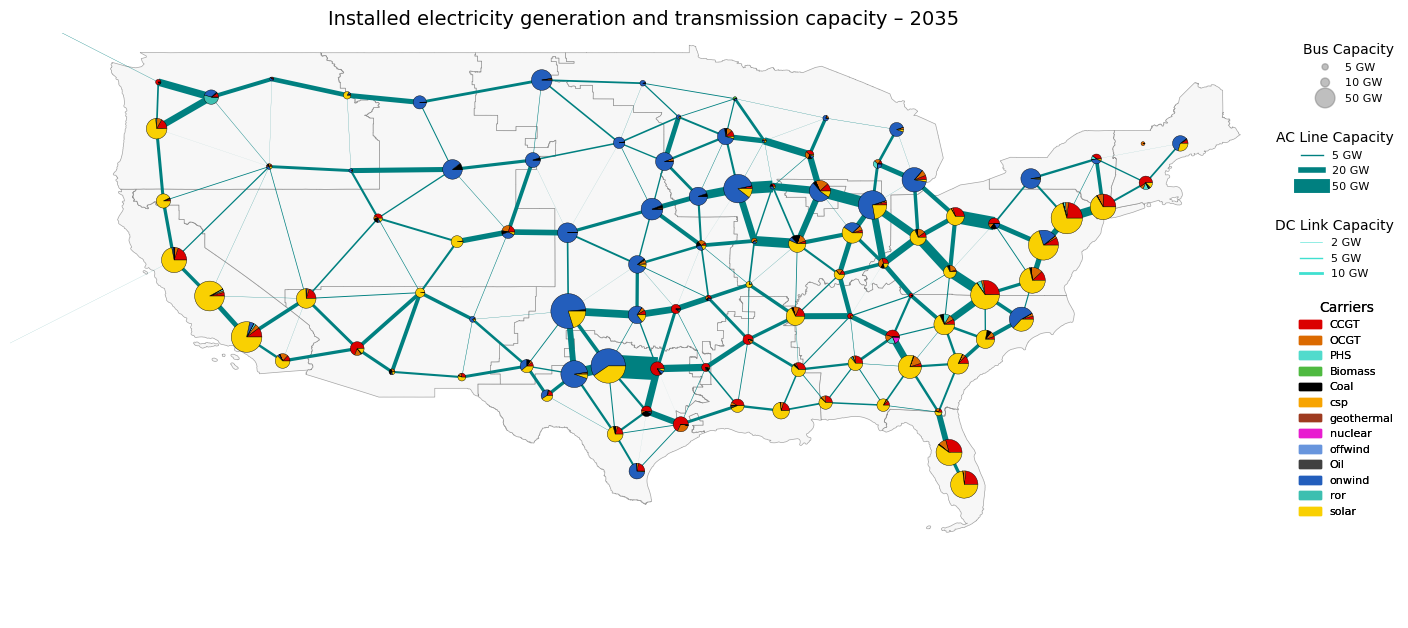

Plotting network: scenario_01_2040


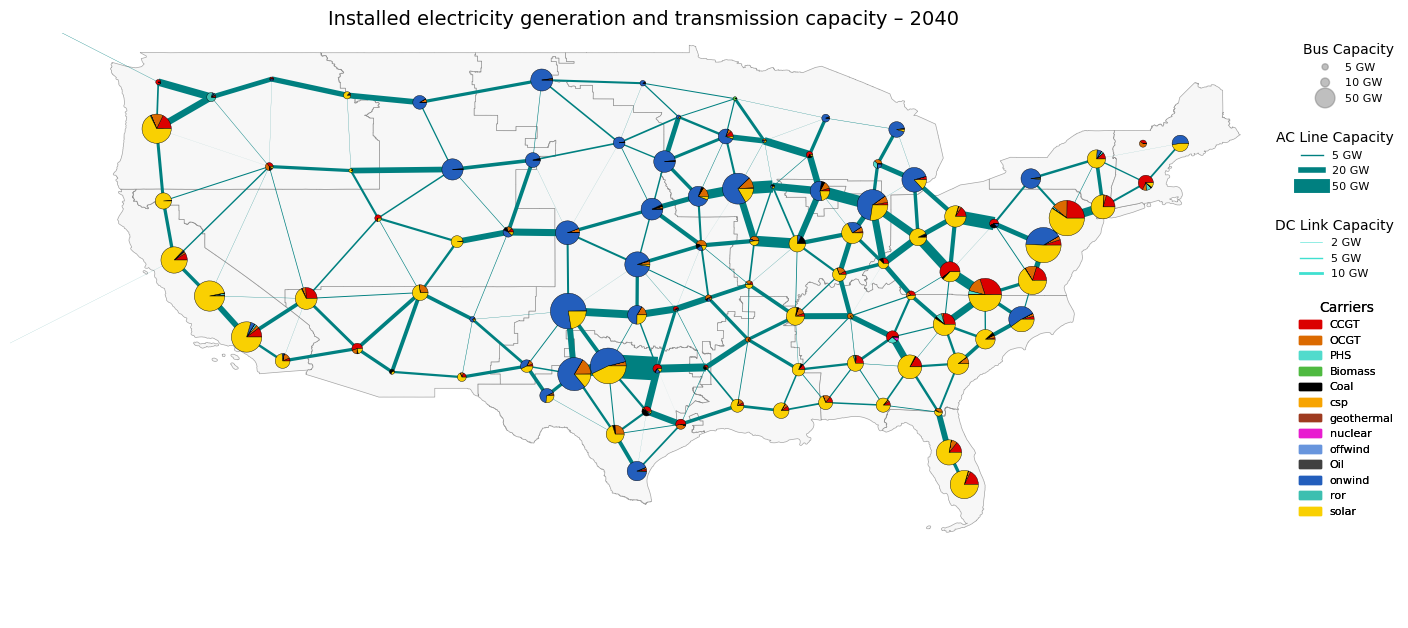

In [22]:
for key, n in networks.items():
    print(f"Plotting network: {key}")
    
    # Electricity generators (or links, using efficiency to scale them)
    gen_carriers = {
        "onwind", "offwind-ac", "offwind-dc", "solar", "solar-rooftop",
        "csp", "nuclear", "geothermal", "ror", "PHS", "Reservoir & Dam"
    }
    link_carriers = {
        "OCGT", "CCGT", "coal", "oil", "biomass", "biomass CHP", "gas CHP"
    }
    
    gen_p_nom_opt = n.generators[n.generators.carrier.isin(gen_carriers)]
    gen_p_nom_opt = gen_p_nom_opt.groupby(["bus", "carrier"]).p_nom_opt.sum()
    
    sto_p_nom_opt = n.storage_units[n.storage_units.carrier.isin(gen_carriers)]
    sto_p_nom_opt = sto_p_nom_opt.groupby(["bus", "carrier"]).p_nom_opt.sum()
    
    link_mask = (
        n.links.efficiency.notnull()
        & (n.links.p_nom_opt > 0)
        & n.links.carrier.isin(link_carriers)
    )
    electricity_links = n.links[link_mask].copy()
    electricity_links["electric_output"] = electricity_links.p_nom_opt * electricity_links.efficiency
    link_p_nom_opt = electricity_links.groupby(["bus1", "carrier"]).electric_output.sum()
    link_p_nom_opt.index = link_p_nom_opt.index.set_names(["bus", "carrier"])
    
    # Join all contributors to electricity generators
    bus_carrier_capacity = pd.concat([gen_p_nom_opt, sto_p_nom_opt, link_p_nom_opt])
    bus_carrier_capacity = bus_carrier_capacity.groupby(level=[0, 1]).sum()
    bus_carrier_capacity = bus_carrier_capacity[bus_carrier_capacity > 0]
    
    # Valid coordinates for buses
    valid_buses = n.buses.dropna(subset=["x", "y"])
    valid_buses = valid_buses[
        (valid_buses["x"] > -200) & (valid_buses["x"] < 200) &
        (valid_buses["y"] > -90) & (valid_buses["y"] < 90)
    ]
    
    # Merge offwind-ac and offwind-dc into a single 'offwind' category
    bus_carrier_capacity = bus_carrier_capacity.reset_index()
    bus_carrier_capacity['carrier'] = bus_carrier_capacity['carrier'].replace({
        'offwind-ac': 'offwind',
        'offwind-dc': 'offwind'
    })
    bus_carrier_capacity = bus_carrier_capacity.groupby(['bus', 'carrier'], as_index=False).sum()
    bus_carrier_capacity = bus_carrier_capacity.set_index(['bus', 'carrier']).squeeze()

    # Capacity per bus and carrier
    capacity_df = bus_carrier_capacity.unstack(fill_value=0)
    capacity_df = capacity_df.loc[capacity_df.index.intersection(valid_buses.index)]
    
    fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={"projection": ccrs.PlateCarree()})
    bbox = box(-130, 20, -60, 50)
    regions_onshore_clipped = regions_onshore.to_crs(epsg=4326).clip(bbox)
    
    # Setup Map
    regions_onshore_clipped.plot(
        ax=ax,
        facecolor='whitesmoke',
        edgecolor='gray',
        alpha=0.7,
        linewidth=0.5,
        zorder=0,
    )

    original_links = n.links.copy()
    n.links = n.links[n.links.index.isin(electricity_links.index)]
    
    # Plot
    line_scale = 5e3
    n.plot(
        ax=ax,
        bus_sizes=0,
        bus_alpha=0,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors='teal',
        link_colors='turquoise',
        color_geomap=False,
        flow=None,
    )
    
    n.links = original_links

    # Pie chart for capacities
    pie_scale = 0.003
    for bus_id, capacities in capacity_df.iterrows():
        x, y = valid_buses.loc[bus_id, ['x', 'y']]
        if not bbox.contains(gpd.points_from_xy([x], [y])[0]):
            continue
    
        values = capacities.values
        total = values.sum()
        if total == 0:
            continue
    
        size = np.clip(np.sqrt(total) * pie_scale, 0.1, 1.5)
        colors = [tech_colors.get(c, 'gray') for c in capacities.index]
    
        start_angle = 0
        for val, color in zip(values, colors):
            if val == 0:
                continue
            angle = 360 * val / total  # proporzione rispetto al totale del nodo
            wedge = Wedge(
                center=(x, y),
                r=size,
                theta1=start_angle,
                theta2=start_angle + angle,
                facecolor=color,
                edgecolor='k',
                linewidth=0.3,
                transform=ccrs.PlateCarree()._as_mpl_transform(ax),
                zorder=5,
            )
            ax.add_patch(wedge)
            start_angle += angle
            
    class HandlerCircle(HandlerPatch):
        def create_artists(self, legend, orig_handle,
                           xdescent, ydescent, width, height, fontsize, trans):
            center = (width / 2, height / 2)
            radius = orig_handle.get_radius()
            p = plt.Circle(center, radius)
            self.update_prop(p, orig_handle, legend)
            p.set_transform(trans)
            return [p]
    
    # Legends
    bus_caps = [5, 10, 50]
    bus_patches = []
    for cap in bus_caps:
        r_in_map = np.sqrt(cap)
        r_pts = r_in_map * fig.dpi * 2
        circ = plt.Circle((0, 0), radius=r_pts / 2 / fig.dpi, color='gray', alpha=0.5)
        bus_patches.append(circ)
    
    bus_legend = ax.legend(
        bus_patches,
        [f"{cap} GW" for cap in bus_caps],
        title="Bus Capacity",
        title_fontsize=10,
        fontsize=8,
        frameon=False,
        handler_map={mpatches.Circle: HandlerCircle()},
        loc='upper right',
        bbox_to_anchor=(1.1, 1.0)
    )
    
    ac_caps = [5e3, 20e3, 50e3]
    ac_patches = [
        mlines.Line2D([], [], color='teal', linewidth=cap / line_scale, label=f"{int(cap/1e3)} GW")
        for cap in ac_caps
    ]
    ac_legend = ax.legend(
        handles=ac_patches,
        title="AC Line Capacity",
        title_fontsize=10,
        fontsize=8,
        frameon=False,
        loc='upper right',
        bbox_to_anchor=(1.1, 0.85)
    )
    
    dc_caps = [2e3, 5e3, 10e3]
    dc_patches = [
        mlines.Line2D([], [], color='turquoise', linewidth=cap / line_scale, label=f"{int(cap/1e3)} GW")
        for cap in dc_caps
    ]
    dc_legend = ax.legend(
        handles=dc_patches,
        title="DC Link Capacity",
        title_fontsize=10,
        fontsize=8,
        frameon=False,
        loc='upper right',
        bbox_to_anchor=(1.1, 0.70)
    )
    
    carrier_handles = [
        mpatches.Patch(color=tech_colors.get(c, 'gray'), label=nice_names.get(c, c))
        for c in sorted(capacity_df.columns) if capacity_df[c].sum() > 0
    ]
    carrier_legend = ax.legend(
        handles=carrier_handles,
        title="Carriers",
        title_fontsize=10,
        fontsize=8,
        frameon=False,
        loc='upper right',
        bbox_to_anchor=(1.1, 0.56),
        ncol=1
    )
    
    ax.add_artist(bus_legend)
    ax.add_artist(ac_legend)
    ax.add_artist(dc_legend)
    ax.add_artist(carrier_legend)
        
    ax.set_extent([-130, -65, 20, 50], crs=ccrs.PlateCarree())
    ax.autoscale(False)
    
    year = key[-4:]  # Extract the year
    ax.set_title(f"Installed electricity generation and transmission capacity – {year}", fontsize=14)
    
    plt.tight_layout()
    plt.show()

In [23]:
totals_by_carrier = {}

for name, net in networks.items():
    # Define carriers used in the plot
    gen_carriers = {
        "onwind", "offwind-ac", "offwind-dc", "solar", "solar-rooftop",
        "csp", "nuclear", "geothermal", "ror", "PHS", "Reservoir & Dam"
    }
    link_carriers = {
        "OCGT", "CCGT", "coal", "oil", "biomass", "biomass CHP", "gas CHP"
    }

    # Generators
    gen = net.generators.copy()
    gen['carrier'] = gen['carrier'].replace({'offwind-ac': 'offwind', 'offwind-dc': 'offwind'})
    gen = gen[gen.carrier.isin(gen_carriers)]
    gen_totals = gen.groupby('carrier')['p_nom_opt'].sum()

    # Storage
    sto = net.storage_units.copy()
    sto = sto[sto.carrier.isin(gen_carriers)]
    sto_totals = sto.groupby('carrier')['p_nom_opt'].sum()

    # Links (output side scaled by efficiency)
    links = net.links.copy()
    mask = (
        links.efficiency.notnull()
        & (links.p_nom_opt > 0)
        & links.carrier.isin(link_carriers)
    )
    links = links[mask]
    links_totals = links.groupby('carrier').apply(
        lambda df: (df['p_nom_opt'] * df['efficiency']).sum()
    )

    # Combine all
    all_totals = pd.concat([gen_totals, sto_totals, links_totals])
    all_totals = all_totals.groupby(all_totals.index).sum()  # Merge duplicates
    all_totals = all_totals[all_totals > 0]
    totals_by_carrier[name] = all_totals

# Build dataframe
carrier_capacity_df = pd.DataFrame(totals_by_carrier).fillna(0)

# Convert MW → GW
carrier_capacity_df = carrier_capacity_df / 1000
carrier_capacity_df = carrier_capacity_df.round(2)

# Filter: only keep rows with at least one nonzero value
carrier_capacity_df = carrier_capacity_df.loc[carrier_capacity_df.sum(axis=1) > 0]

# Add label
carrier_capacity_df.index.name = "carrier (GW)"

display(carrier_capacity_df)


Base_2023  scenario_01_2030  scenario_01_2035  scenario_01_2040
carrier (GW)                                                                 
CCGT             300.00            287.39            289.28            248.44
OCGT             167.94            137.61            130.16            182.48
PHS               21.98             21.98             21.98             21.98
biomass            3.07              2.22              2.05              1.64
coal             109.89             43.44             33.45             23.88
geothermal         1.29              1.19              1.10              0.82
nuclear           52.40              7.35              2.54              1.27
oil                8.04              3.41              2.19              0.32
onwind           132.76            722.74            729.65            824.25
ror                9.87              9.60              9.60              6.07
solar             60.39            375.34            899.68           1112.05

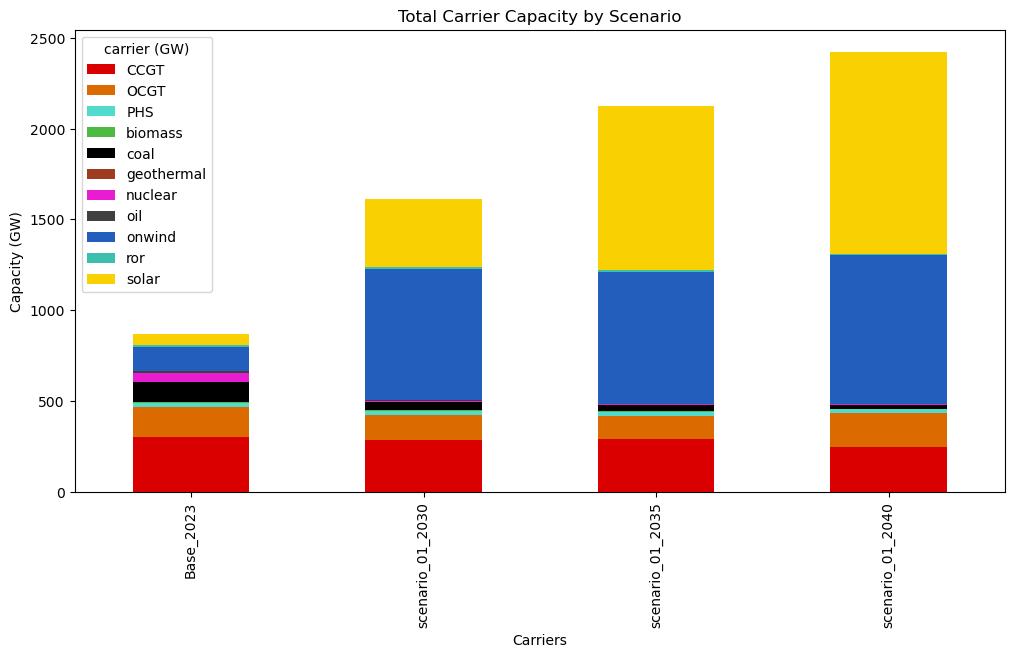

In [24]:
carrier_order = list(carrier_capacity_df.index)
color_list = [tech_colors.get(carrier, 'gray') for carrier in carrier_order]

carrier_capacity_df.T.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    title="Total Carrier Capacity by Scenario",
    ylabel="Capacity (GW)",
    xlabel="Carriers",
    color=color_list,
)
plt.show()

### 4.2. Map: Total Installed Hydrogen Electrolyzer Capacity
*This map visualizes the spatial distribution and total capacity (in GW) of different electrolyzer technologies (e.g., AEL, PEM).*

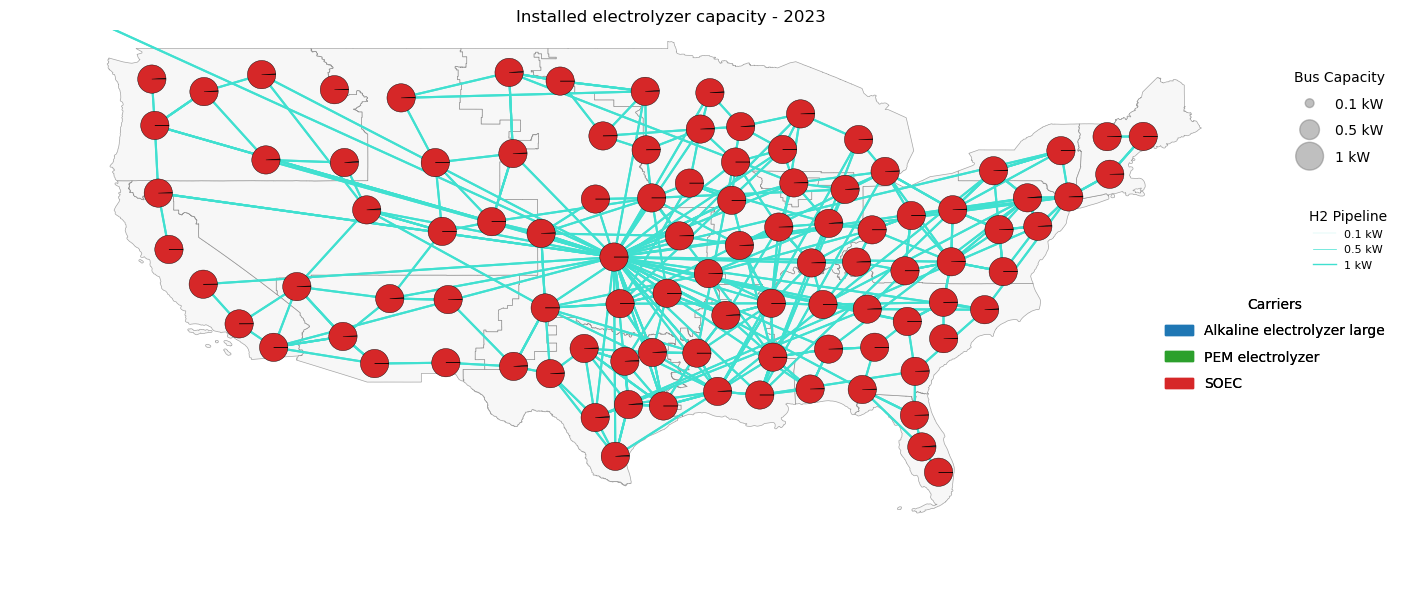

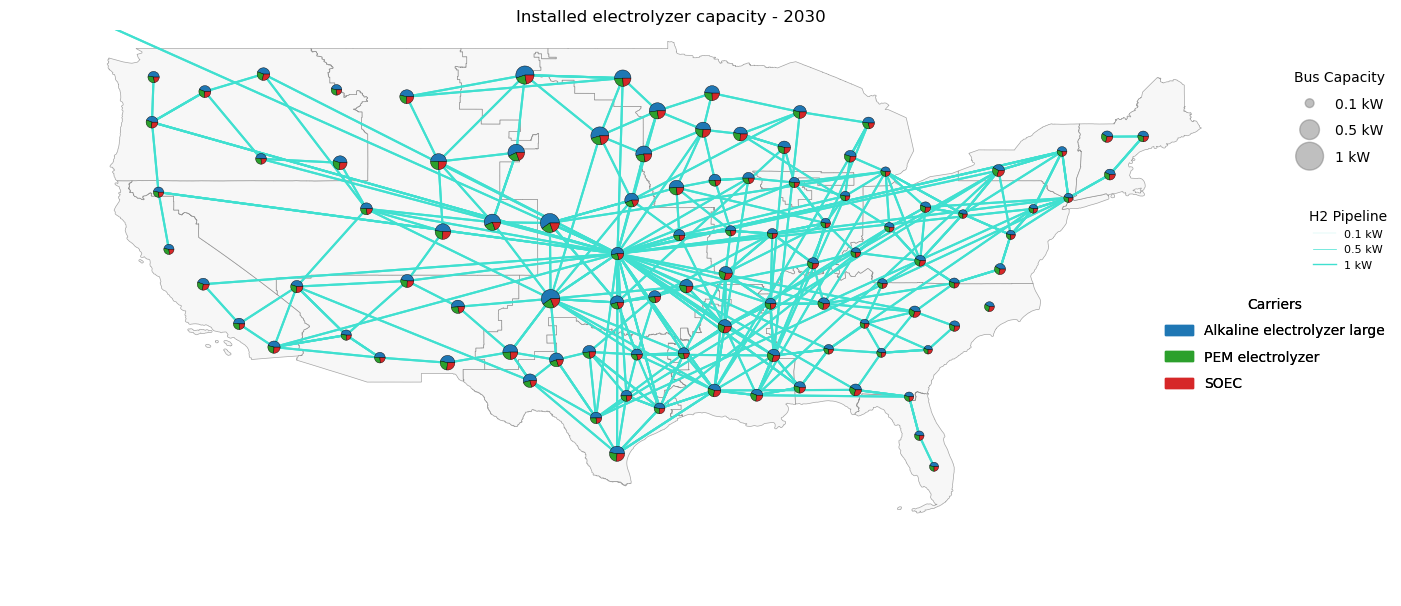

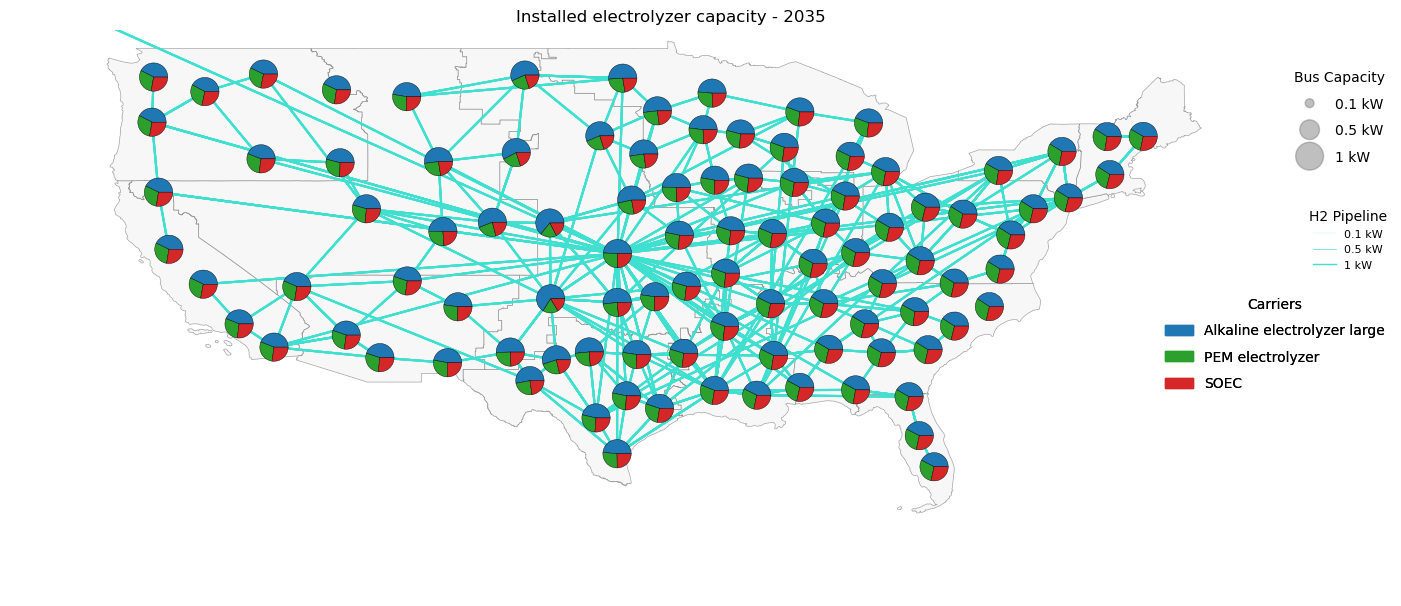

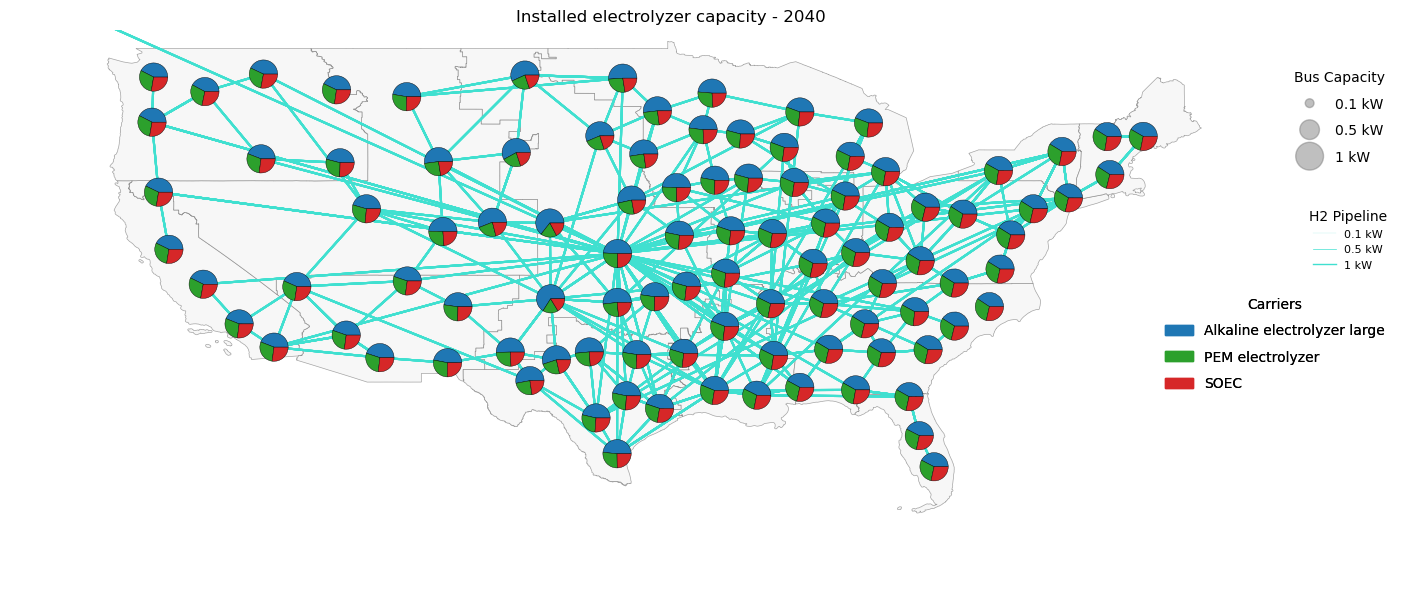

In [25]:
for idx, network in enumerate(networks.keys()):
    plot_h2_capacities_map(networks[network], network, tech_colors, nice_names, regions_onshore)

Plotting H2 capacities bar chart for Base_2023...


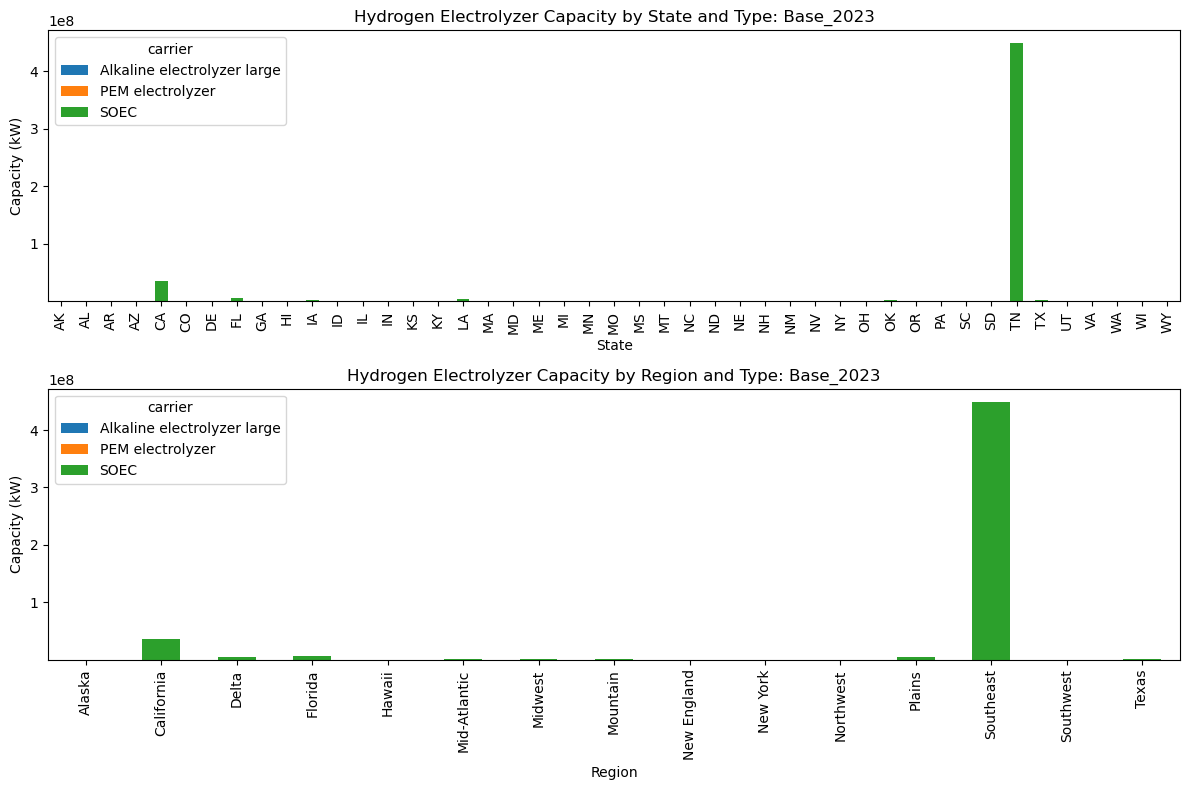

Plotting H2 capacities bar chart for scenario_01_2030...


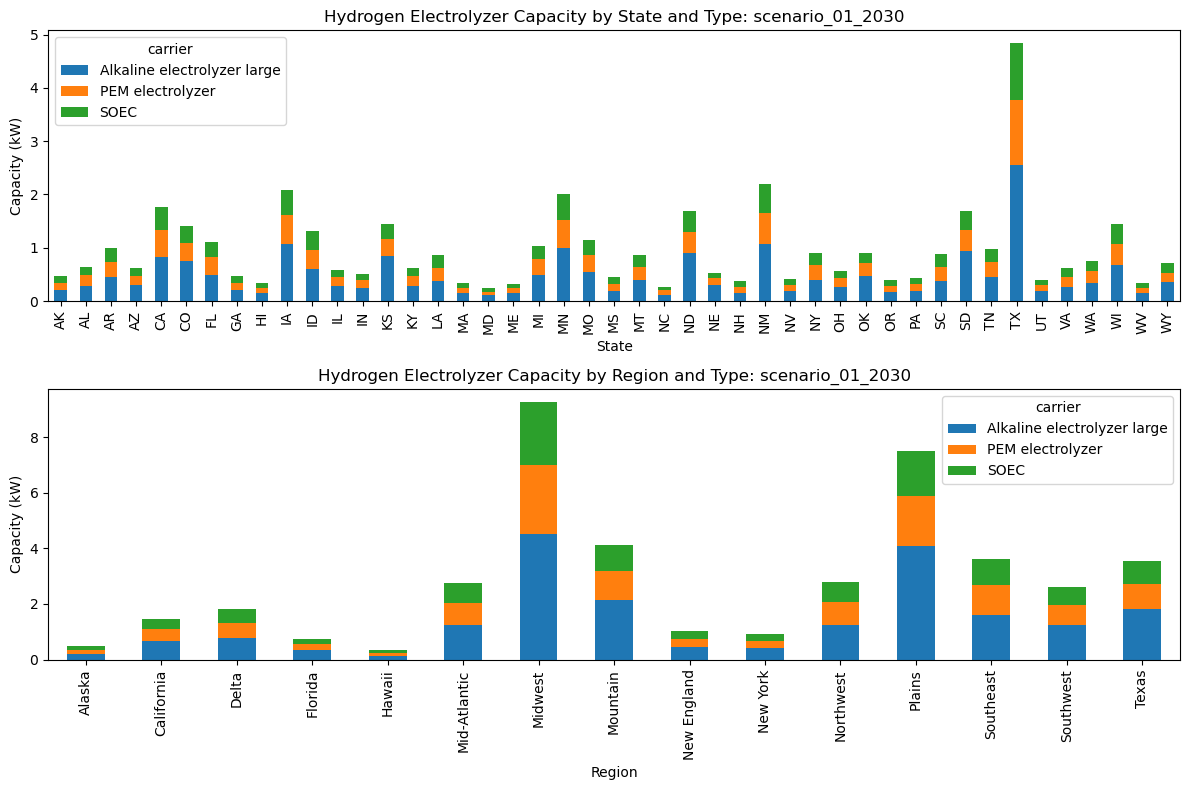

Plotting H2 capacities bar chart for scenario_01_2035...


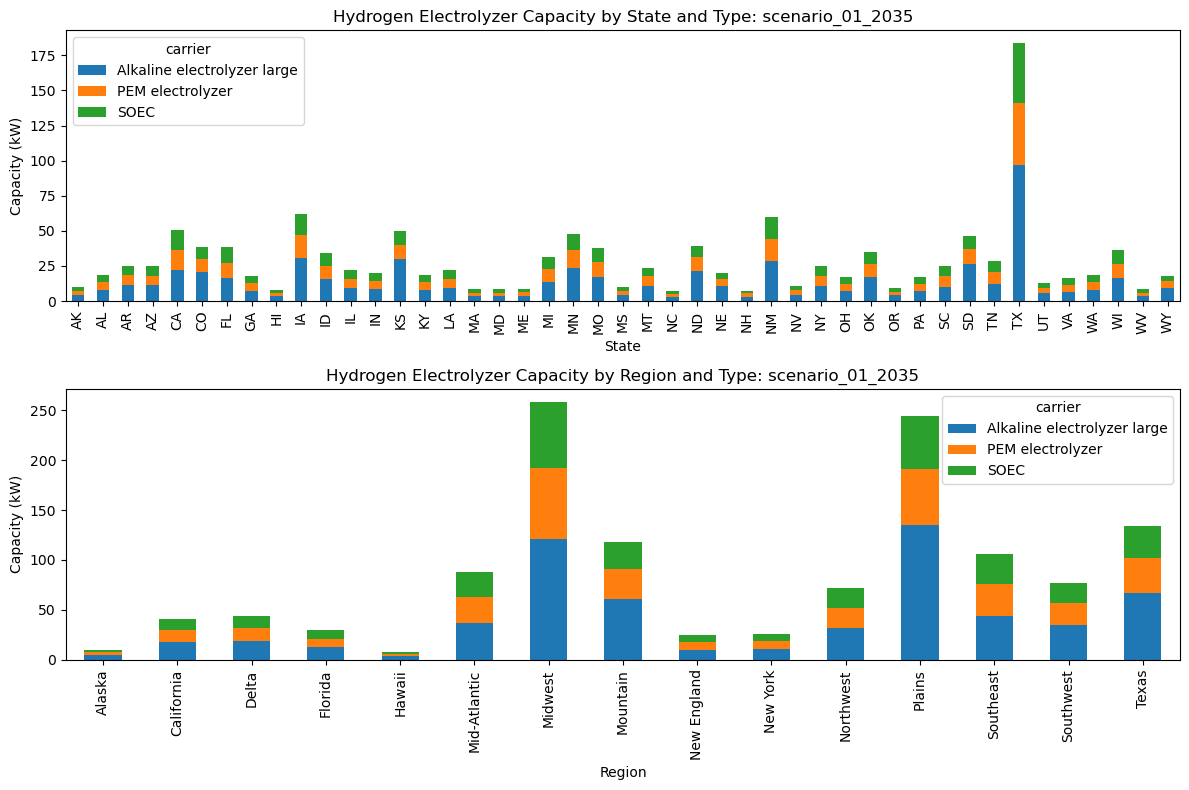

Plotting H2 capacities bar chart for scenario_01_2040...


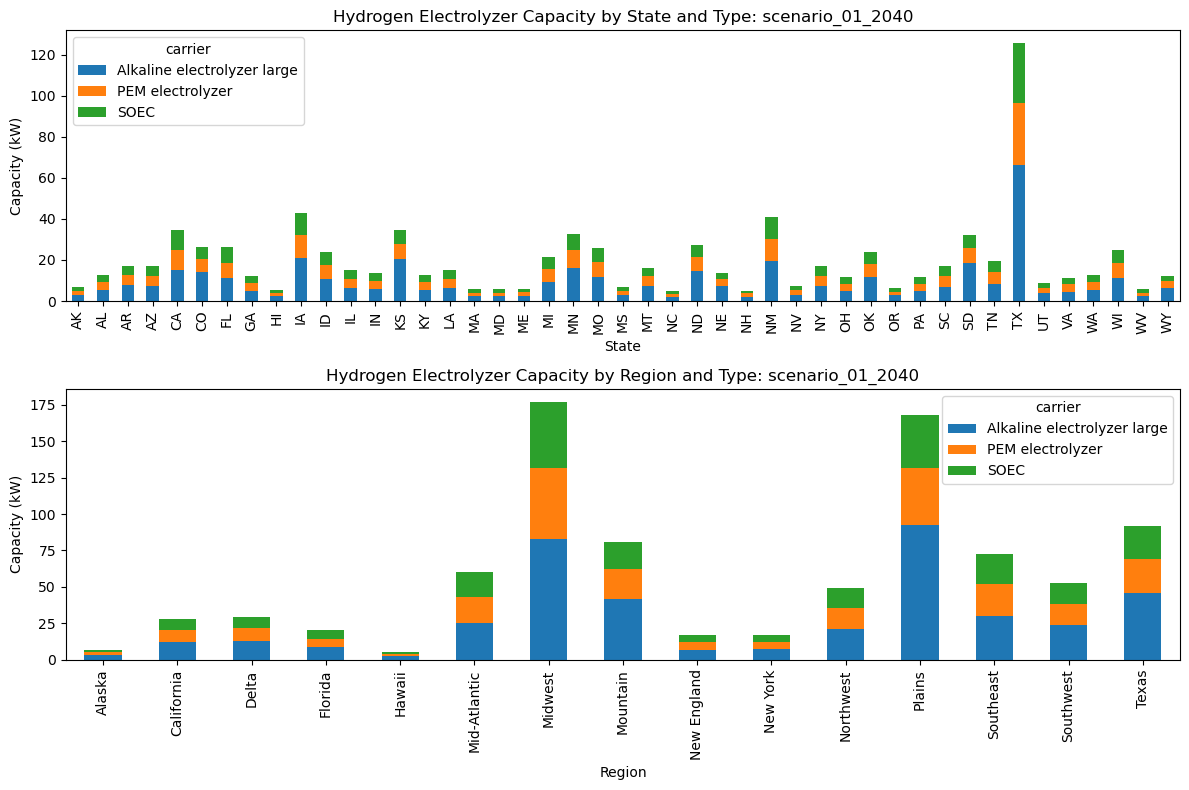

In [26]:
for idx, network in enumerate(networks.keys()):
    print(f"Plotting H2 capacities bar chart for {network}...")
    plot_h2_capacities_bar(networks[network], network)

In [27]:
for idx, network in enumerate(networks.keys()):
    h2_state_cap = compute_h2_capacities(networks[network]).groupby(['state'])[['Alkaline electrolyzer large', 'PEM electrolyzer', 'SOEC']].sum().round(2)
    print(f"Hydrogen capacities for {network}:")
    from IPython.display import display
    display(h2_state_cap.sort_values(by=list(h2_state_cap.columns), ascending=False).T)

Hydrogen capacities for Base_2023:


state                                TX           CA       MN          FL  \
carrier                                                                     
Alkaline electrolyzer large       78.37        44.39    33.43       27.29   
PEM electrolyzer                  32.92        18.33    14.11       11.52   
SOEC                         1269834.04  35999181.21  6352.34  5761147.84   

state                                  TN       MO        NY          IA  \
carrier                                                                    
Alkaline electrolyzer large  2.695000e+01    26.91     26.82       26.73   
PEM electrolyzer             1.123000e+01    11.22     11.14       11.25   
SOEC                         4.488506e+08  5444.31  29883.33  1329260.01   

state                             NM          LA       AZ        GA        KY  \
carrier                                                                         
Alkaline electrolyzer large    26.25       26.16    26.14     25.66     25.66   
PEM electrolyzer               11.11       10.95    11.05     10.81     10.69   
SOEC                         7028.09  4521206.74  5527.08  28960.66  52938.42   

state                             ID       WI       AL       MI       IN  \
carrier                                                                    
Alkaline electrolyzer large    25.60    24.62    19.03    18.64    18.57   
PEM electrolyzer               10.72    10.30     7.91     7.81     7.75   
SOEC                         3311.22  4871.62  3822.88  3673.40  1866.91   

state                                OK       PA         CO         OH  \
carrier                                                                  
Alkaline electrolyzer large       18.45    17.95      17.56      17.51   
PEM electrolyzer                   7.75     7.54       7.36       7.26   
SOEC                         2648579.57  2334.20  151840.83  602583.97   

state                             IL       SD          NE       WA         KS  \
carrier                                                                         
Alkaline electrolyzer large    17.42    17.38       17.36    17.36      17.32   
PEM electrolyzer                7.24     7.30        7.26     7.18       7.25   
SOEC                         3447.40  6094.59  1233888.23  2494.59  234369.16   

state                               SC       NC         VA         ND  \
carrier                                                                 
Alkaline electrolyzer large      17.27    16.35      16.33      16.08   
PEM electrolyzer                  7.34     6.93       6.85       6.80   
SOEC                         635091.44  5060.34  428418.40  303254.54   

state                             MT      UT       DE       MD       ME  \
carrier                                                                   
Alkaline electrolyzer large    15.82    9.30     9.03     8.97     8.96   
PEM electrolyzer                7.17    3.90     3.78     3.77     3.82   
SOEC                         2951.29  816.69  1174.06  1874.96  6477.38   

state                            AK         WY         MS        OR       NV  \
carrier                                                                        
Alkaline electrolyzer large    8.54       8.41       8.40      8.18     8.17   
PEM electrolyzer               3.60       3.53       3.53      3.36     3.44   
SOEC                         640.84  174492.97  422579.35  84289.69  1511.50   

state                             MA      AR       NH       HI  
carrier                                                         
Alkaline electrolyzer large     8.15    8.10     7.94     7.04  
PEM electrolyzer                3.39    3.39     3.47     3.46  
SOEC                         2245.02  970.47  1936.04  1553.79

Hydrogen capacities for scenario_01_2030:


state                          TX    IA    NM    MN    SD    ND    KS    CA  \
carrier                                                                       
Alkaline electrolyzer large  2.55  1.08  1.07  1.00  0.94  0.90  0.84  0.82   
PEM electrolyzer             1.21  0.54  0.59  0.51  0.39  0.40  0.32  0.51   
SOEC                         1.07  0.47  0.54  0.49  0.35  0.39  0.29  0.44   

state                          CO    WI    ID    MO    FL    MI    OK    TN  \
carrier                                                                       
Alkaline electrolyzer large  0.74  0.68  0.60  0.54  0.50  0.48  0.47  0.45   
PEM electrolyzer             0.35  0.40  0.37  0.32  0.33  0.30  0.23  0.29   
SOEC                         0.32  0.37  0.35  0.29  0.29  0.25  0.19  0.25   

state                          AR    NY    MT    SC    LA    WY    WA    AZ  \
carrier                                                                       
Alkaline electrolyzer large  0.45  0.40  0.40  0.38  0.38  0.35  0.34  0.30   
PEM electrolyzer             0.28  0.27  0.24  0.26  0.25  0.18  0.22  0.17   
SOEC                         0.27  0.24  0.22  0.24  0.23  0.18  0.19  0.15   

state                          NE    AL    KY    IL    VA    OH    IN    AK  \
carrier                                                                       
Alkaline electrolyzer large  0.30  0.29  0.28  0.28  0.27  0.25  0.24  0.21   
PEM electrolyzer             0.13  0.19  0.18  0.17  0.19  0.17  0.15  0.14   
SOEC                         0.10  0.16  0.16  0.14  0.16  0.14  0.12  0.13   

state                          GA    UT    MS    PA    NV    OR    NH    ME  \
carrier                                                                       
Alkaline electrolyzer large  0.21  0.20  0.19  0.19  0.19  0.17  0.15  0.15   
PEM electrolyzer             0.14  0.11  0.13  0.13  0.12  0.11  0.11  0.10   
SOEC                         0.12  0.09  0.13  0.11  0.11  0.10  0.11  0.08   

state                          HI    MA    WV    NC    MD  
carrier                                                    
Alkaline electrolyzer large  0.14  0.14  0.14  0.11  0.11  
PEM electrolyzer             0.10  0.10  0.10  0.08  0.07  
SOEC                         0.10  0.09  0.09  0.07  0.06

Hydrogen capacities for scenario_01_2035:


state                           TX     IA     KS     NM     SD     MN     CA  \
carrier                                                                        
Alkaline electrolyzer large  96.75  30.60  29.60  28.43  26.51  23.56  21.90   
PEM electrolyzer             44.58  16.47  10.50  15.99  10.61  12.60  14.78   
SOEC                         42.32  15.28   9.89  15.09   9.38  11.25  13.85   

state                           ND     CO     OK     MO     WI     FL     ID  \
carrier                                                                        
Alkaline electrolyzer large  21.45  20.60  17.34  17.10  16.34  16.13  15.36   
PEM electrolyzer              9.75   9.44   8.89  10.61  10.35  11.32   9.92   
SOEC                          8.30   8.56   8.42   9.90   9.69  10.82   9.25   

state                           MI     TN     AR     AZ     MT     NE     NY  \
carrier                                                                        
Alkaline electrolyzer large  13.47  12.04  11.31  11.07  10.84  10.63  10.47   
PEM electrolyzer              9.12   8.47   7.09   6.94   6.67   4.84   7.70   
SOEC                          8.53   8.09   6.74   6.66   6.24   4.40   7.07   

state                           SC    IL    LA    WY    IN    WA    KY    AL  \
carrier                                                                        
Alkaline electrolyzer large  10.33  9.63  9.55  9.37  8.61  7.94  7.90  7.77   
PEM electrolyzer              7.59  6.38  6.38  4.59  5.92  5.56  5.59  5.53   
SOEC                          6.99  6.01  6.15  4.06  5.56  5.26  5.33  5.29   

state                          GA    OH    PA    VA    UT    NV    AK    MS  \
carrier                                                                       
Alkaline electrolyzer large  7.28  7.19  6.91  6.77  5.94  4.50  4.37  4.26   
PEM electrolyzer             5.27  5.22  5.07  5.00  3.63  3.02  2.98  2.96   
SOEC                         5.05  4.96  4.83  4.69  3.47  2.84  2.72  2.73   

state                          OR    ME    WV    MD    HI    MA    NH    NC  
carrier                                                                      
Alkaline electrolyzer large  3.97  3.65  3.48  3.45  3.43  3.39  3.07  2.99  
PEM electrolyzer             2.79  2.63  2.55  2.53  2.47  2.51  2.33  2.26  
SOEC                         2.59  2.47  2.38  2.40  2.14  2.40  2.06  2.10

Hydrogen capacities for scenario_01_2040:


state                           TX     IA     KS     NM     SD     MN     CA  \
carrier                                                                        
Alkaline electrolyzer large  66.07  20.99  20.53  19.43  18.41  16.16  14.96   
PEM electrolyzer             30.55  11.31   7.24  10.96   7.32   8.65  10.12   
SOEC                         28.91  10.46   6.80  10.31   6.45   7.70   9.46   

state                           ND     CO     OK     MO     WI     FL     ID  \
carrier                                                                        
Alkaline electrolyzer large  14.80  14.10  11.84  11.70  11.20  11.00  10.52   
PEM electrolyzer              6.71   6.48   6.09   7.27   7.10   7.74   6.81   
SOEC                          5.70   5.86   5.74   6.76   6.64   7.37   6.33   

state                          MI    TN    AR    AZ    MT    NE    NY    SC  \
carrier                                                                       
Alkaline electrolyzer large  9.23  8.23  7.72  7.56  7.43  7.30  7.15  7.07   
PEM electrolyzer             6.26  5.80  4.85  4.75  4.58  3.33  5.27  5.20   
SOEC                         5.84  5.51  4.60  4.54  4.27  3.02  4.82  4.78   

state                          IL    LA    WY    IN    WA    KY    AL    GA  \
carrier                                                                       
Alkaline electrolyzer large  6.59  6.51  6.45  5.89  5.43  5.40  5.30  4.97   
PEM electrolyzer             4.37  4.36  3.15  4.06  3.81  3.83  3.78  3.61   
SOEC                         4.10  4.19  2.79  3.80  3.59  3.64  3.60  3.44   

state                          OH    PA    VA    UT    NV    AK    MS    OR  \
carrier                                                                       
Alkaline electrolyzer large  4.92  4.73  4.63  4.07  3.09  2.98  2.90  2.72   
PEM electrolyzer             3.58  3.47  3.43  2.49  2.08  2.04  2.02  1.91   
SOEC                         3.39  3.30  3.20  2.37  1.95  1.86  1.86  1.78   

state                          ME    WV    MD    HI    MA    NH    NC  
carrier                                                                
Alkaline electrolyzer large  2.50  2.38  2.36  2.35  2.32  2.10  2.05  
PEM electrolyzer             1.81  1.75  1.73  1.69  1.72  1.60  1.55  
SOEC                         1.69  1.63  1.64  1.47  1.64  1.41  1.44

In [28]:
for idx, network in enumerate(networks.keys()):
    h2_state_cap = compute_h2_capacities(networks[network]).groupby(['region'])[['Alkaline electrolyzer large', 'PEM electrolyzer', 'SOEC']].sum().round(2)
    print(f"Hydrogen capacities for {network}:")
    from IPython.display import display
    display(h2_state_cap.sort_values(by=list(h2_state_cap.columns), ascending=False).T)

Hydrogen capacities for Base_2023:


region                          Midwest     Southeast      Plains  \
carrier                                                             
Alkaline electrolyzer large      156.02  1.052700e+02      104.09   
PEM electrolyzer                  65.40  4.421000e+01       43.73   
SOEC                         1653002.81  4.495236e+08  4516614.11   

region                       Mid-Atlantic      Texas   Mountain  Northwest  \
carrier                                                                      
Alkaline electrolyzer large         96.41      70.05      62.11      58.60   
PEM electrolyzer                    40.30      29.42      25.98      24.94   
SOEC                           1089788.00  880418.94  332086.61   91703.94   

region                       Southwest       Delta   California     Florida  \
carrier                                                                       
Alkaline electrolyzer large      51.53       42.66        35.09       27.29   
PEM electrolyzer                 21.78       17.87        14.47       11.52   
SOEC                          12968.78  4944756.56  35997122.07  5761147.84   

region                       New York  New England  Alaska   Hawaii  
carrier                                                              
Alkaline electrolyzer large     26.82        25.05    8.54     7.04  
PEM electrolyzer                11.14        10.68    3.60     3.46  
SOEC                         29883.33     10658.44  640.84  1553.79

Hydrogen capacities for scenario_01_2030:


region                       Midwest  Plains  Mountain  Texas  Southeast  \
carrier                                                                    
Alkaline electrolyzer large     4.52    4.10      2.13   1.80       1.60   
PEM electrolyzer                2.50    1.79      1.06   0.92       1.07   
SOEC                            2.26    1.61      0.95   0.81       0.95   

region                       Northwest  Southwest  Mid-Atlantic  Delta  \
carrier                                                                  
Alkaline electrolyzer large       1.26       1.24          1.23   0.79   
PEM electrolyzer                  0.80       0.72          0.82   0.51   
SOEC                              0.71       0.65          0.70   0.50   

region                       California  New England  New York  Florida  \
carrier                                                                   
Alkaline electrolyzer large        0.68         0.44      0.40     0.33   
PEM electrolyzer                   0.42         0.31      0.27     0.21   
SOEC                               0.37         0.27      0.24     0.18   

region                       Alaska  Hawaii  
carrier                                      
Alkaline electrolyzer large    0.21    0.14  
PEM electrolyzer               0.14    0.10  
SOEC                           0.13    0.10

Hydrogen capacities for scenario_01_2035:


region                       Plains  Midwest  Texas  Mountain  Southeast  \
carrier                                                                    
Alkaline electrolyzer large  134.62   120.65  66.90     60.91      44.08   
PEM electrolyzer              56.95    71.75  34.56     29.79      31.78   
SOEC                          52.78    66.15  32.89     27.33      29.96   

region                       Mid-Atlantic  Southwest  Northwest  Delta  \
carrier                                                                  
Alkaline electrolyzer large         36.47      34.89      31.22  18.81   
PEM electrolyzer                    26.31      21.37      21.01  12.65   
SOEC                                24.86      20.21      19.63  11.93   

region                       California  Florida  New York  New England  \
carrier                                                                   
Alkaline electrolyzer large       17.85    12.45     10.47        10.11   
PEM electrolyzer                  11.97     8.66      7.70         7.48   
SOEC                              11.25     8.38      7.07         6.93   

region                       Alaska  Hawaii  
carrier                                      
Alkaline electrolyzer large    4.37    3.43  
PEM electrolyzer               2.98    2.47  
SOEC                           2.72    2.14

Hydrogen capacities for scenario_01_2040:


region                       Plains  Midwest  Texas  Mountain  Southeast  \
carrier                                                                    
Alkaline electrolyzer large   92.52    82.69  45.70     41.92      30.12   
PEM electrolyzer              39.12    49.23  23.67     20.46      21.75   
SOEC                          36.15    45.26  22.46     18.72      20.43   

region                       Mid-Atlantic  Southwest  Northwest  Delta  \
carrier                                                                  
Alkaline electrolyzer large         24.96      23.85      21.37  12.82   
PEM electrolyzer                    18.03      14.64      14.41   8.64   
SOEC                                16.98      13.81      13.42   8.13   

region                       California  Florida  New York  New England  \
carrier                                                                   
Alkaline electrolyzer large       12.19     8.50      7.15         6.92   
PEM electrolyzer                   8.20     5.92      5.27         5.12   
SOEC                               7.68     5.71      4.82         4.73   

region                       Alaska  Hawaii  
carrier                                      
Alkaline electrolyzer large    2.98    2.35  
PEM electrolyzer               2.04    1.69  
SOEC                           1.86    1.47

### 4.3. Map: Total Installed Fischer-Tropsch (FT) Capacity
*A map showing where FT synthesis plants are built and their respective capacities, crucial for e-kerosene production.*

Plotting FT map for: Base_2023
Plotting FT map for: scenario_01_2030
Plotting FT map for: scenario_01_2035
Plotting FT map for: scenario_01_2040


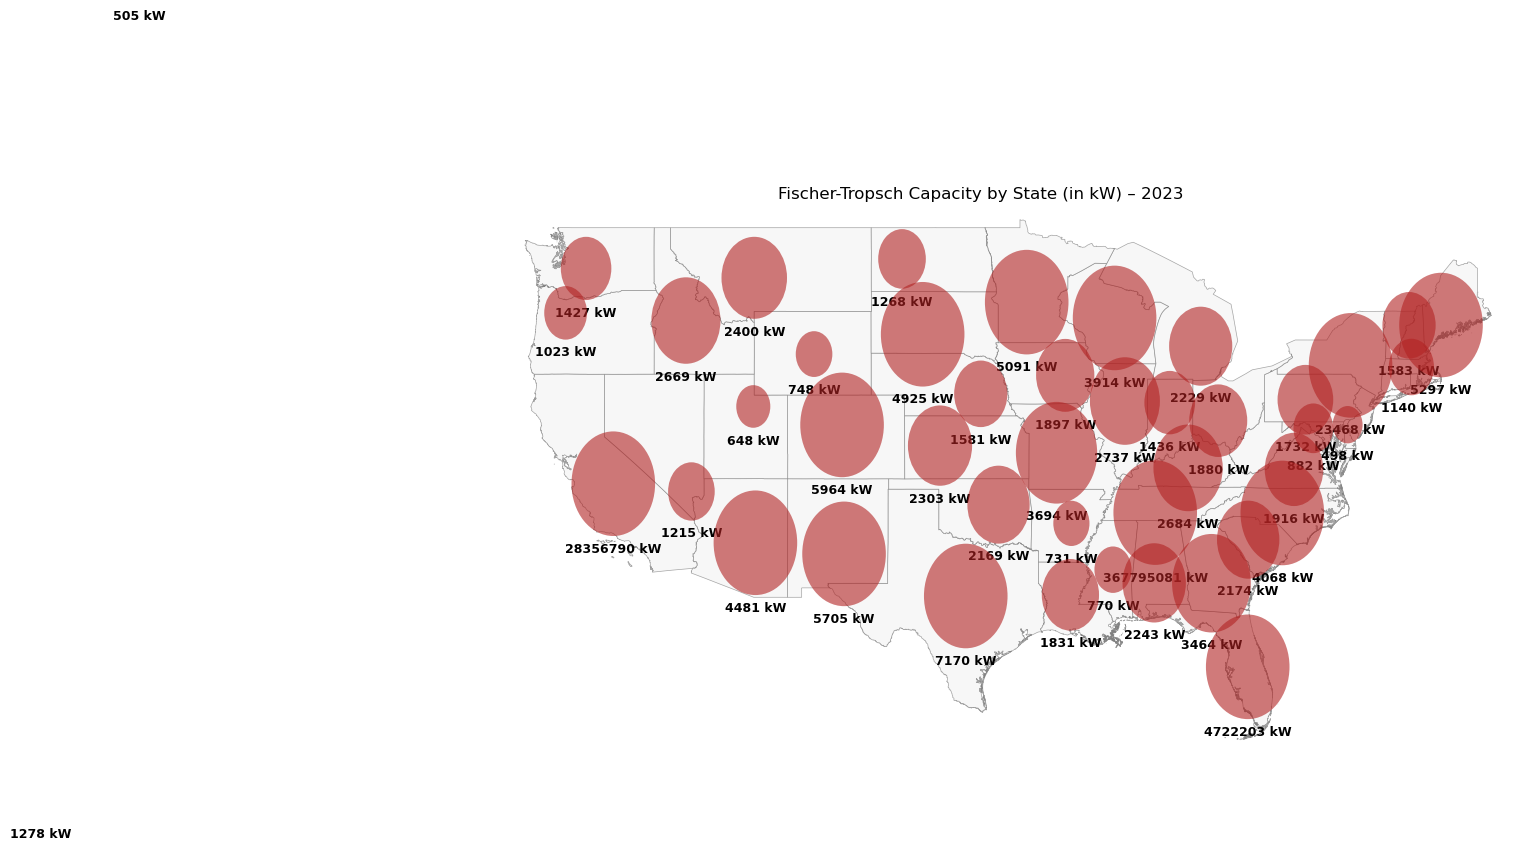

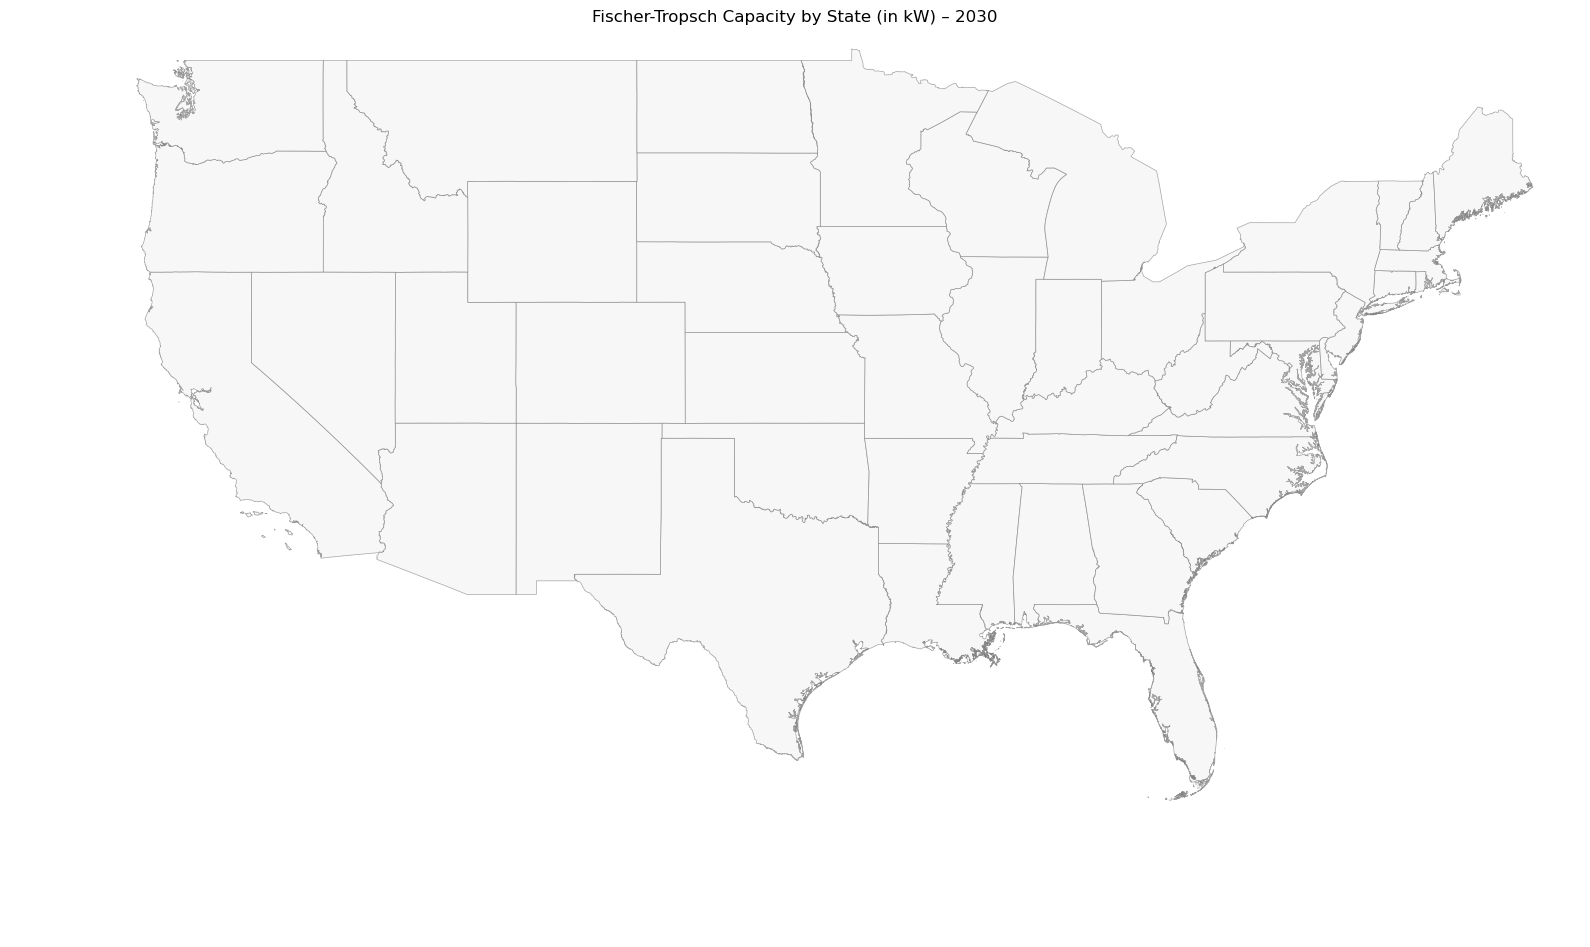

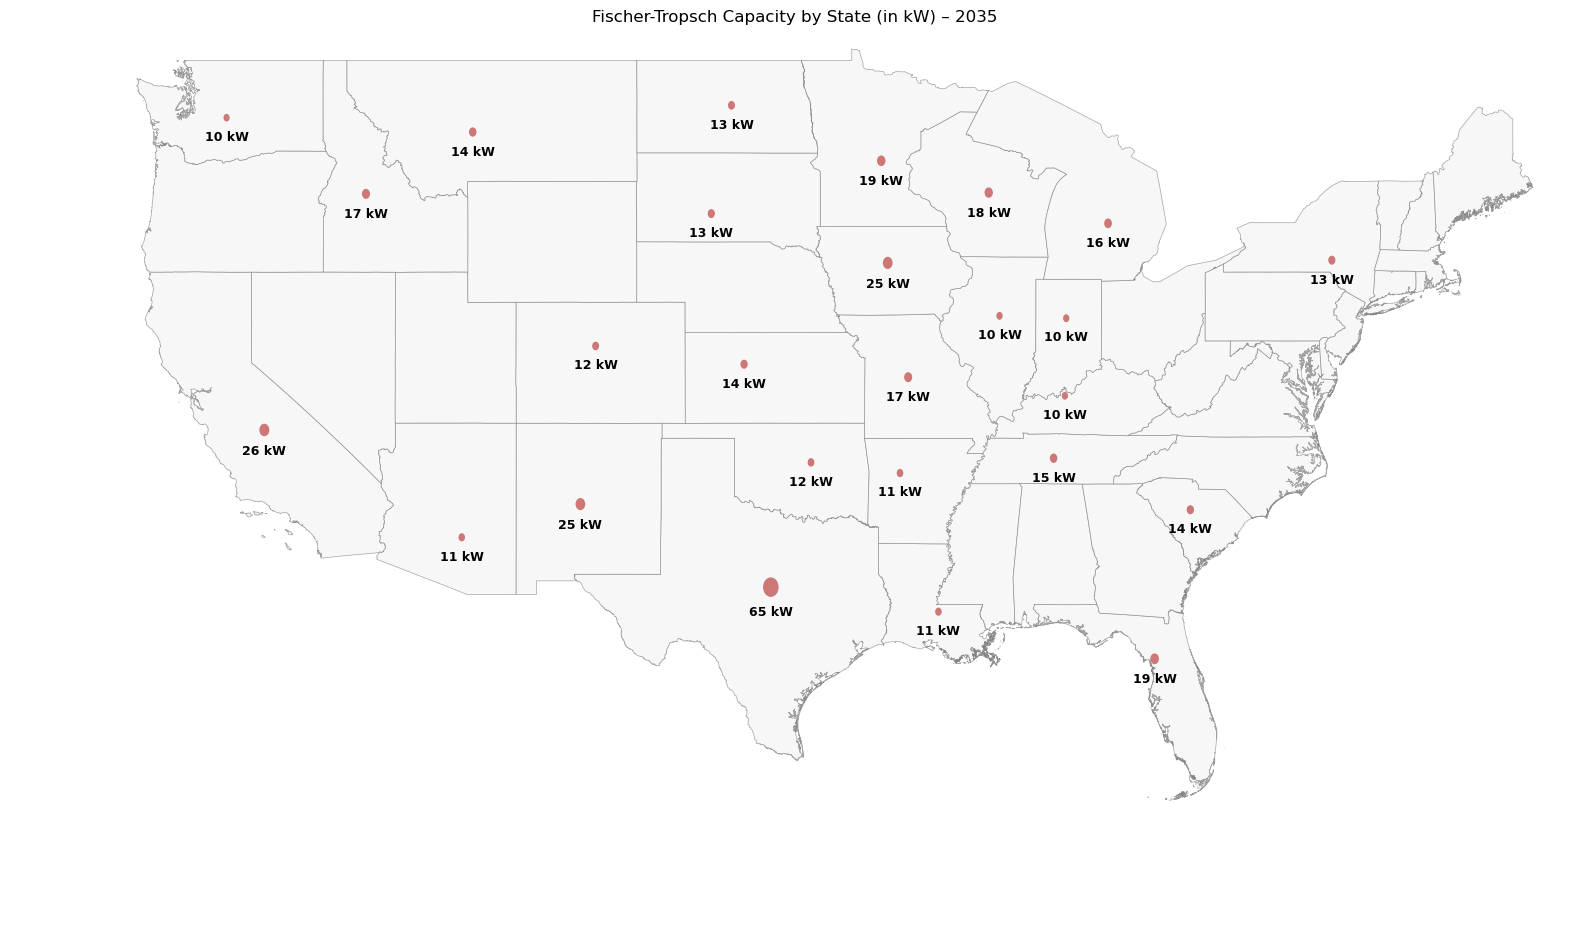

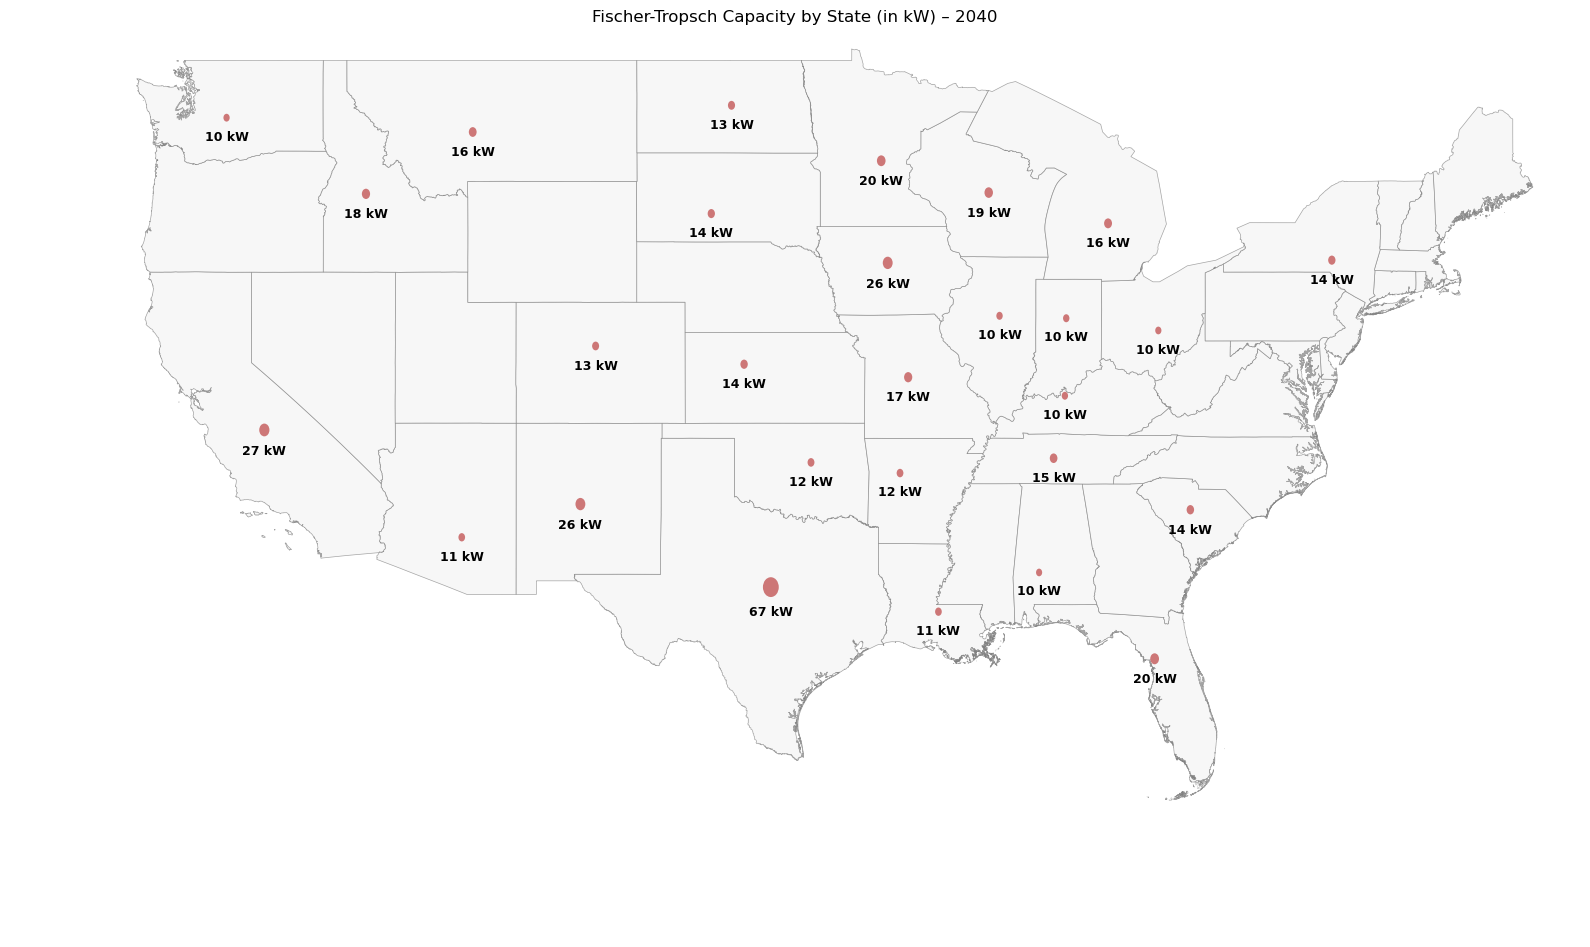

In [29]:
for name, net in networks.items():
    print(f"Plotting FT map for: {name}")
    fig, ax, data = create_ft_capacity_map(
        net.copy(),
        path_shapes=state_shapes_path,
        network_name=name,
        min_capacity_kw=10
    )

Plotting FT map by grid region: Base_2023
Plotting FT map by grid region: scenario_01_2030
Plotting FT map by grid region: scenario_01_2035
Plotting FT map by grid region: scenario_01_2040


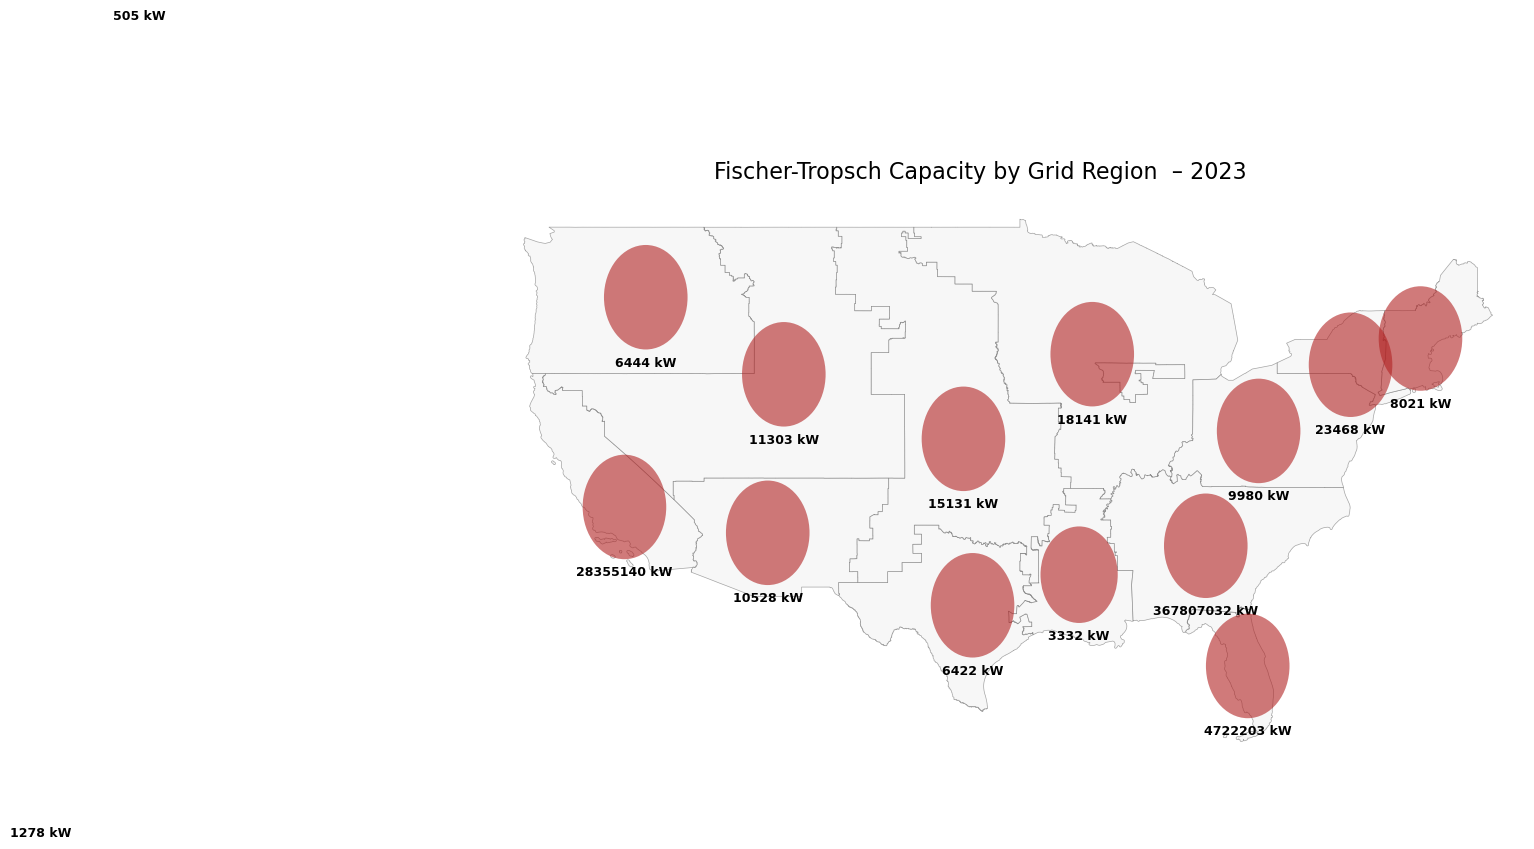

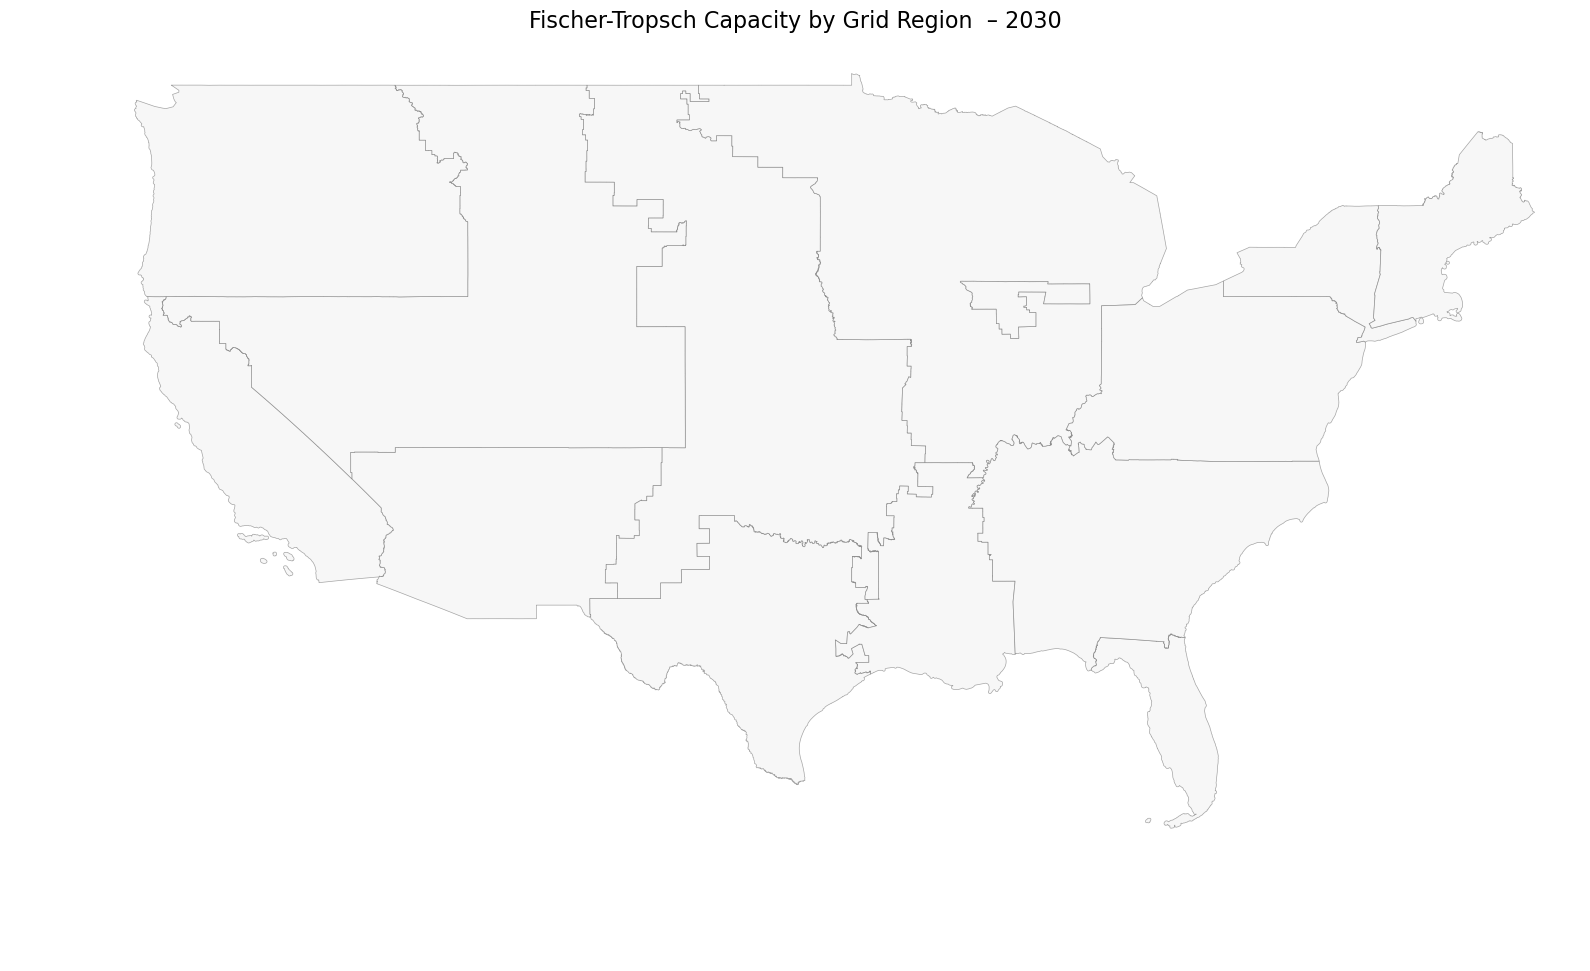

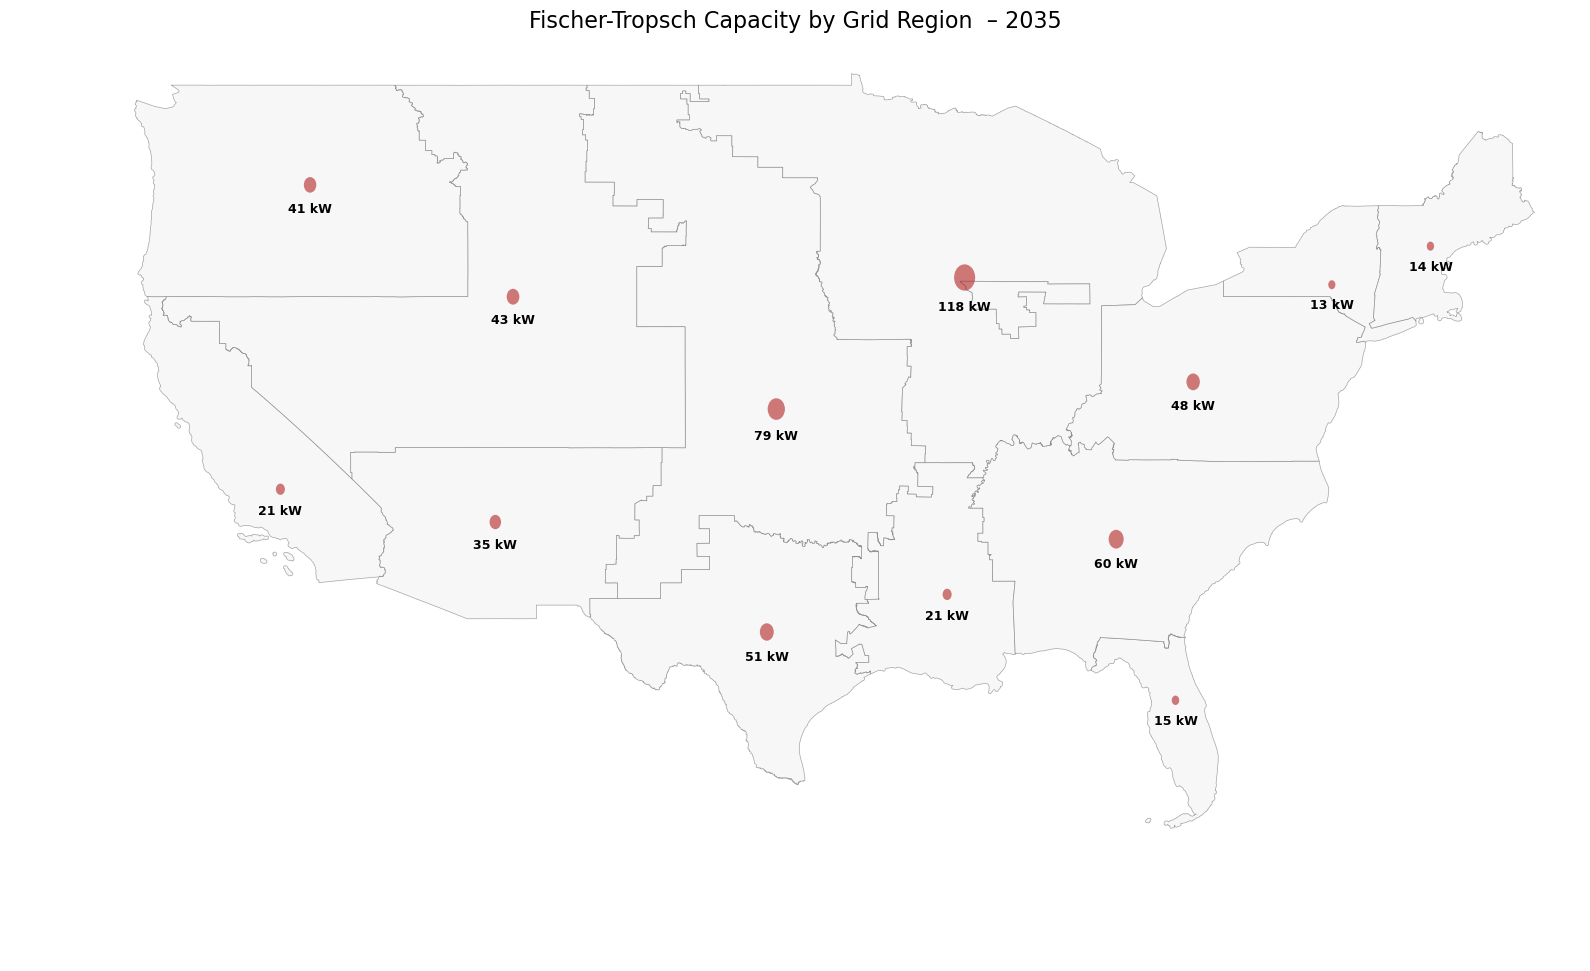

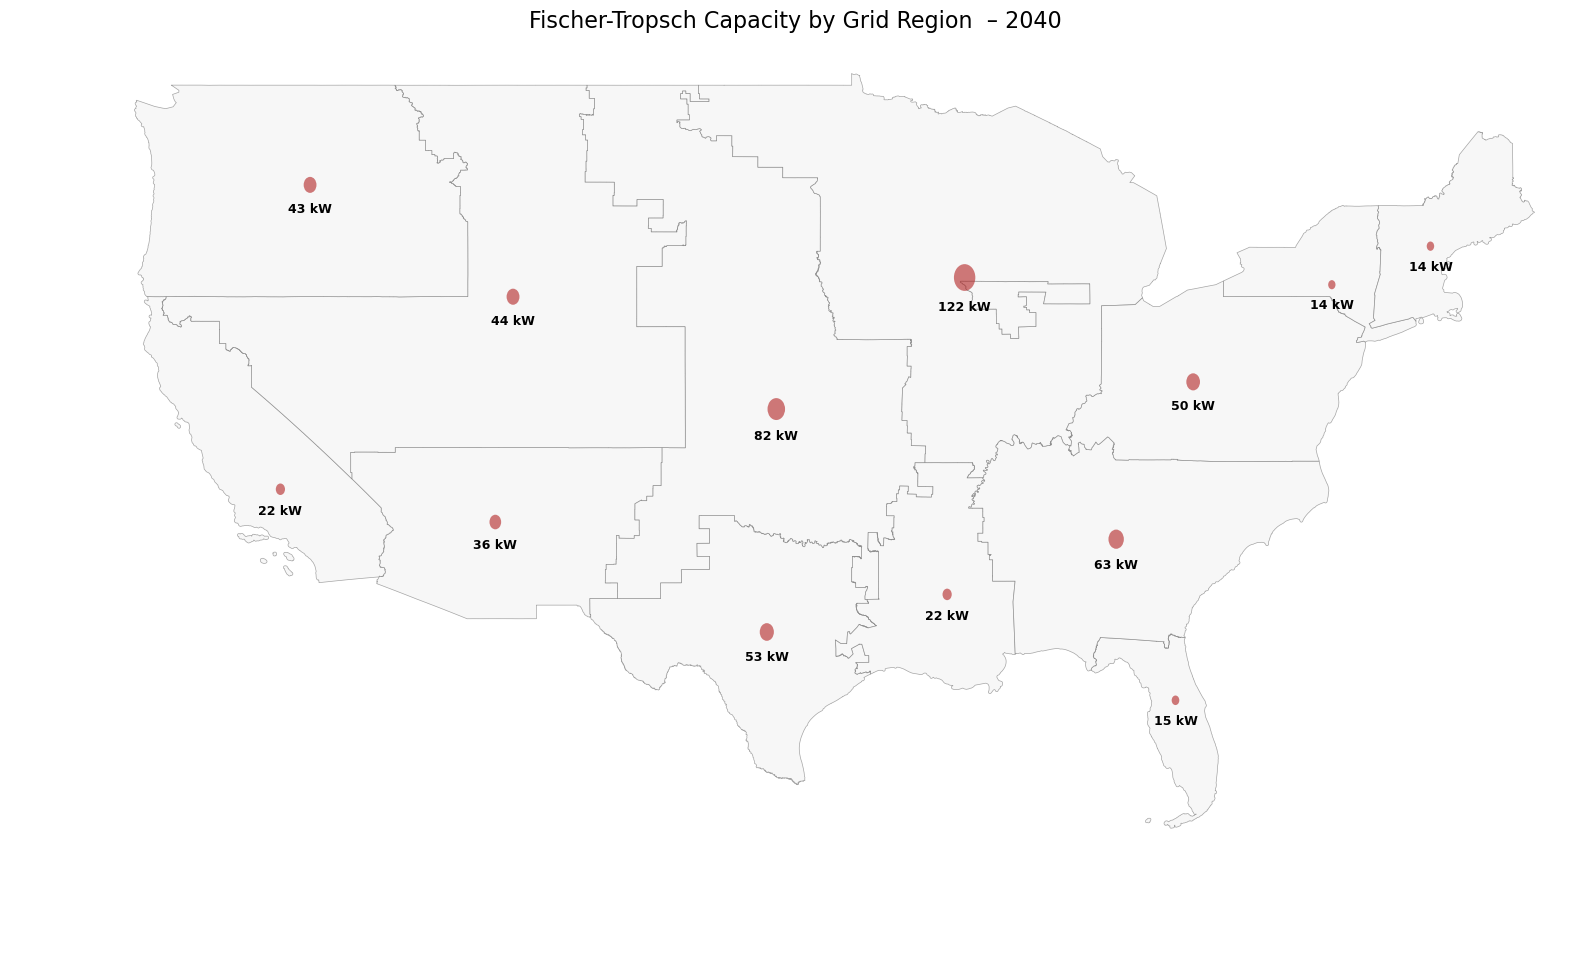

In [30]:
for name, net in networks.items():
    print(f"Plotting FT map by grid region: {name}")
    fig, ax, data = create_ft_capacity_by_grid_region_map(
        net.copy(),
        path_shapes=grid_region_shapes_path,
        network_name=name,
        min_capacity_kw=10
    )

### 4.4. Map: Expanded Capacity per Planning Horizon
*This analysis focuses only on the **newly added** capacity for key technologies (Electricity, H2, FT) within the planning period, rather than the total capacity.*

In [31]:
# Code to calculate the difference between p_nom_opt and p_nom
# and plot the expansion on a map.
pass

---

## 5. Operational Analysis: How Does the System Work?

*This section explores the temporal dispatch of different technologies to meet demand throughout the year.*

### 5.1. Annual Electricity & Hydrogen Dispatch
*A line plot showing the generation from different carriers (for electricity) and production from electrolyzers (for hydrogen) for every hour of the year. This reveals the operational dynamics and intermittency management.*

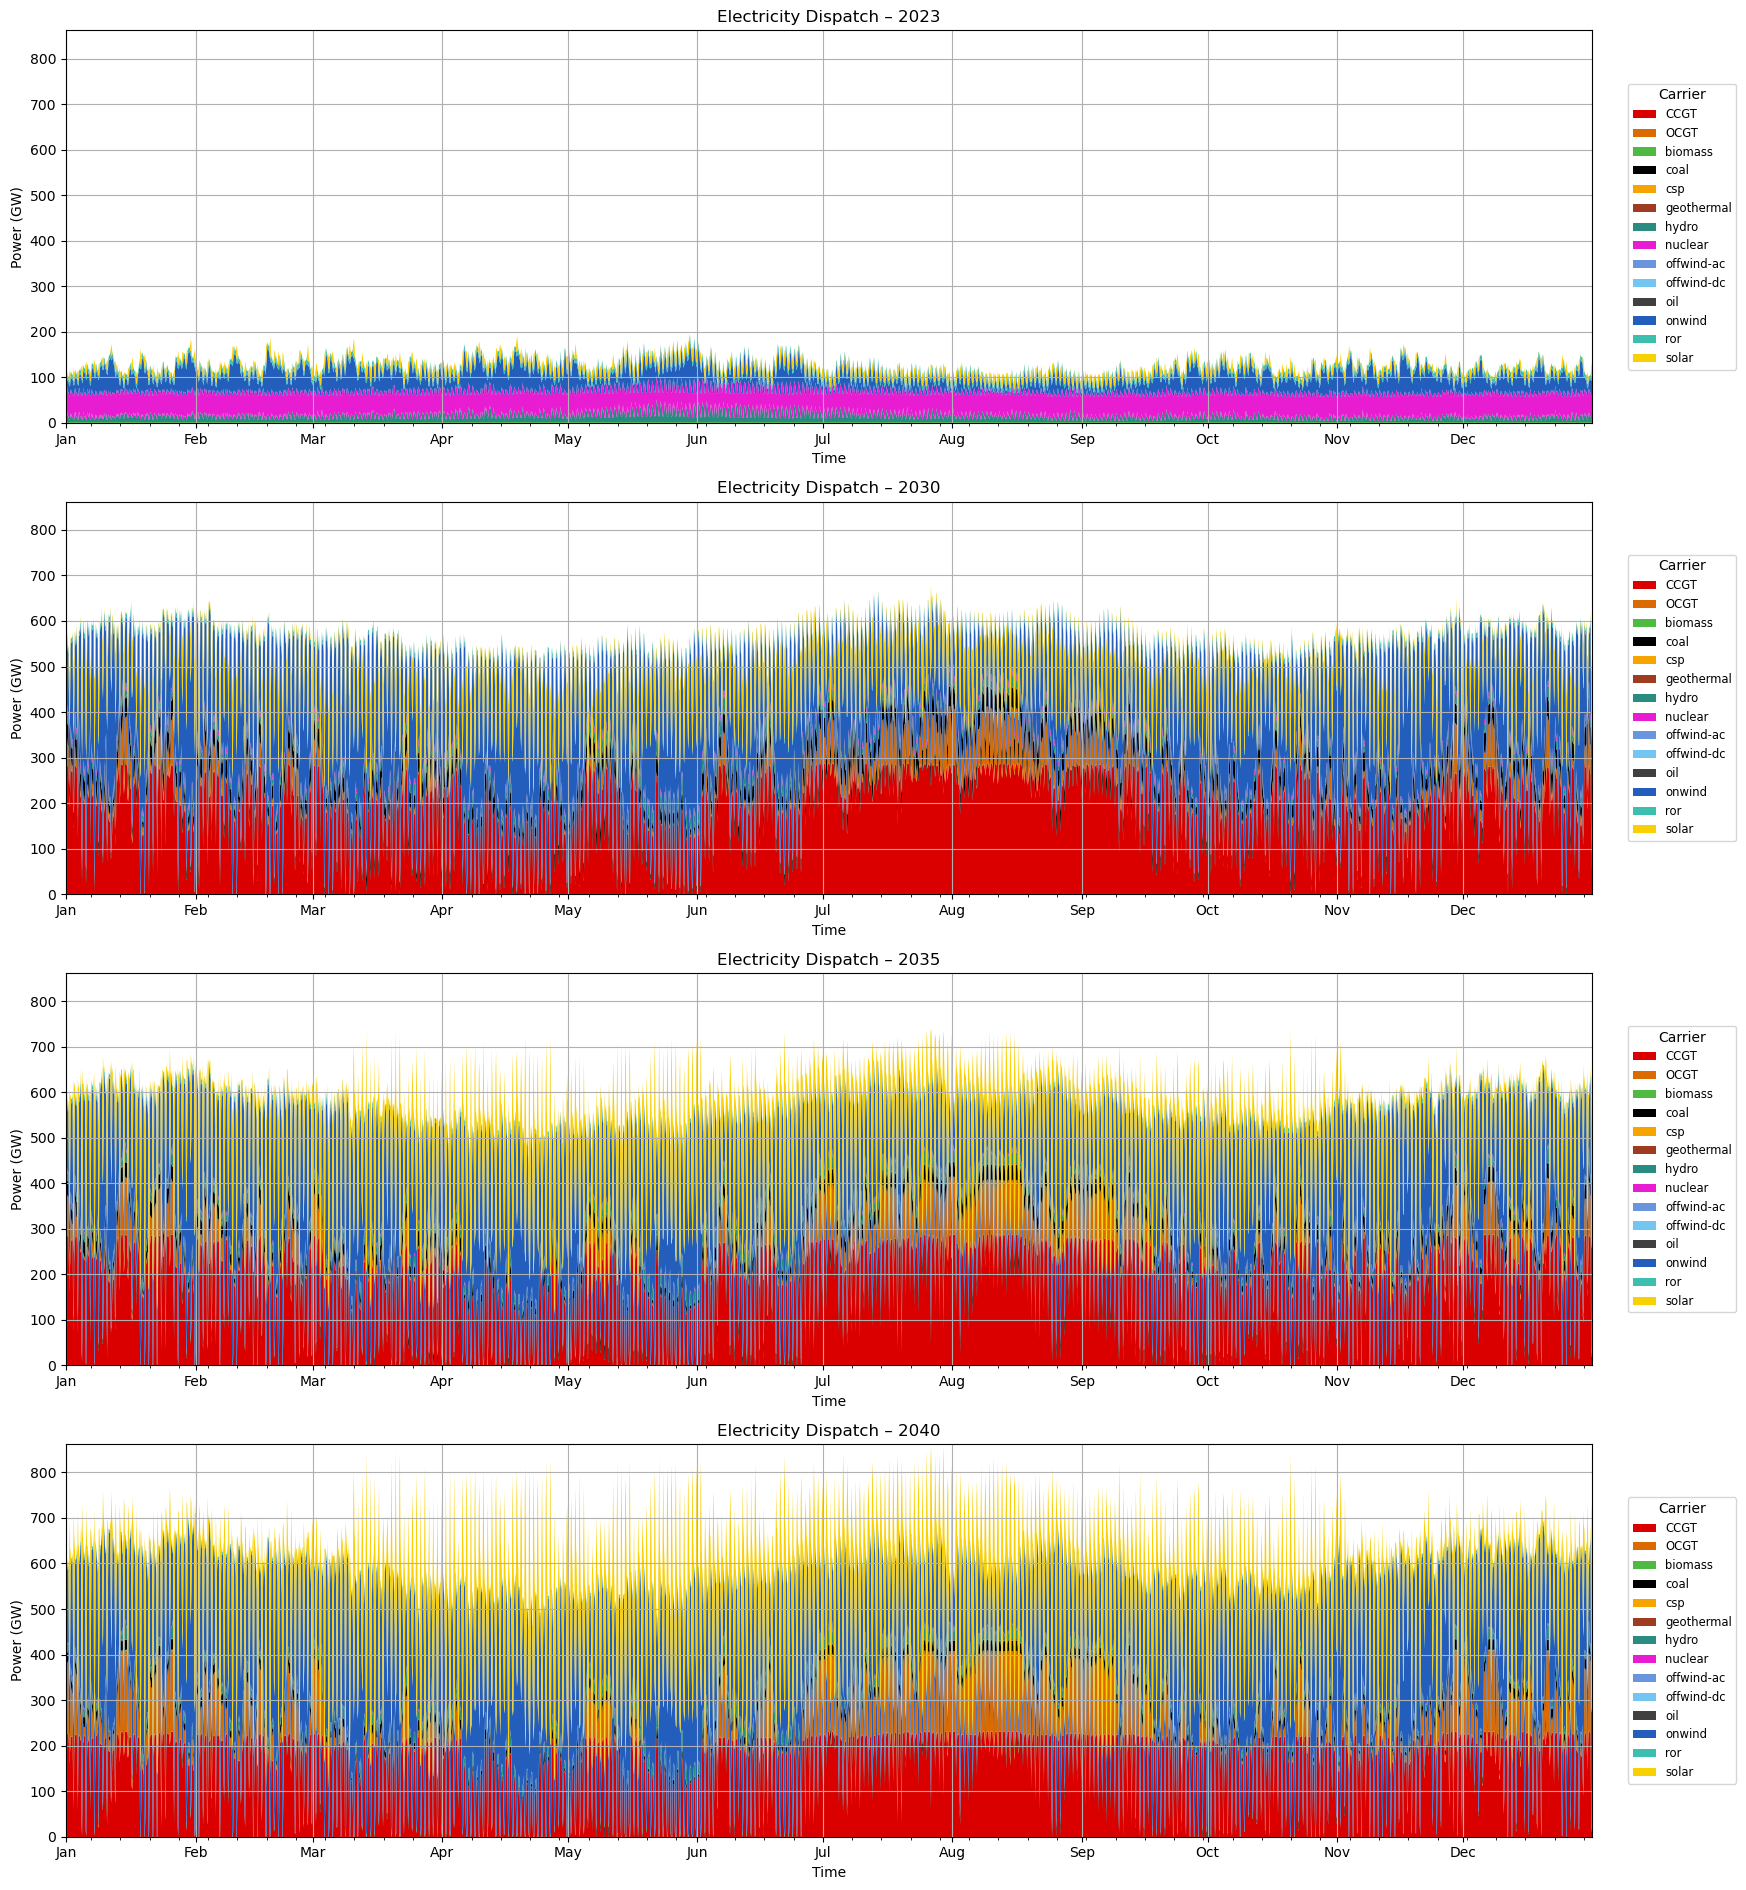

In [32]:
summary_list = []
max_y = 0

for key, n in networks.items():
    total_gwh, supply_gw = calculate_dispatch(n)
    summary_list.append({"Network": key, "Total Dispatch (GWh)": total_gwh})
    max_y = max(max_y, supply_gw.sum(axis=1).max())

ymax = max_y

fig, axes = plt.subplots(len(networks), 1, figsize=(22, 5 * len(networks)))

if len(networks) == 1:
    axes = [axes]

for ax, (key, n) in zip(axes, networks.items()):
    _, supply_gw = calculate_dispatch(n)
    supply_gw.plot.area(
        ax=ax,
        stacked=True,
        linewidth=0,
        color=[tech_colors.get(c, 'gray') for c in supply_gw.columns],
        legend=False
    )
    
    year = key[-4:]  # Extract the year
    ax.set_title(f"Electricity Dispatch – {year}")
    ax.set_ylabel("Power (GW)")
    ax.set_ylim(0, ymax)
    ax.grid(True)
    
    start = supply_gw.index.min().replace(day=1)
    end = supply_gw.index.max()
    month_starts = pd.date_range(start=start, end=end, freq='MS')
    
    ax.set_xlim(start, end)
    ax.set_xticks(month_starts)
    ax.set_xticklabels(month_starts.strftime('%b'))
    ax.tick_params(axis='x', which='both', labelbottom=True)
    ax.set_xlabel("Time")

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles, labels,
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        title='Carrier',
        fontsize='small',
        title_fontsize='medium'
    )

axes[-1].set_xlabel("Time")
plt.tight_layout(rect=[0, 0.05, 0.80, 1])
plt.show()

In [33]:
generation_summary = {}

for key, network in networks.items():
    year = key[-4:]  # Extract the year
    generation_summary[year] = calculate_total_generation_by_carrier(network)

generation_df = pd.DataFrame.from_dict(generation_summary, orient='index').fillna(0)
generation_df.index.name = "Generation (TWh)"
generation_df = generation_df.sort_index().round(2)

fossil_order = ['coal', 'lignite', 'oil', 'OCGT', 'CCGT', 'biomass']
renewables_order = ['hydro', 'ror', 'solar', 'onwind', 'offwind-ac', 'offwind-dc', 'csp', 'geothermal', 'nuclear']
preferred_order = fossil_order + renewables_order

available_cols = generation_df.columns.tolist()
ordered_cols = [c for c in preferred_order if c in available_cols] + \
               [c for c in available_cols if c not in preferred_order]

generation_df = generation_df[ordered_cols]
generation_df["Total"] = generation_df.sum(axis=1).round(2)

display(generation_df)

coal    oil    OCGT     CCGT  biomass   hydro    ror  \
Generation (TWh)                                                           
2023                0.00   0.00    0.00     0.00    26.91  126.00  86.47   
2030              301.48  13.24  177.58  1621.06     0.03  125.01  82.07   
2035              210.45   8.99  202.34  1488.57     0.06  122.11  75.51   
2040              143.23   0.69  361.53  1324.31     0.16  120.98  46.79   

                    solar   onwind  offwind-dc  csp  geothermal  nuclear  \
Generation (TWh)                                                           
2023                85.69   343.05         0.0  0.0        0.00   458.98   
2030               510.64  1878.51         0.0  0.0        9.41    56.27   
2035              1181.39  1879.34         0.0  0.0        8.01    19.65   
2040              1449.39  2082.82         0.0  0.0        5.83     9.51   

                    Total  
Generation (TWh)           
2023              1127.10  
2030              4775.30  
2035              5196.42  
2040              5545.24

---

## 6. Economic Analysis: What Are the Unit Costs?

*We break down the system costs to find the levelized cost of key energy vectors in different locations.*

### 6.1. Map: Levelized Cost of Electricity (LCOE)
*A map displaying the LCOE for each grid region.*

In [34]:
shapes = gpd.read_file(grid_region_shapes_path)

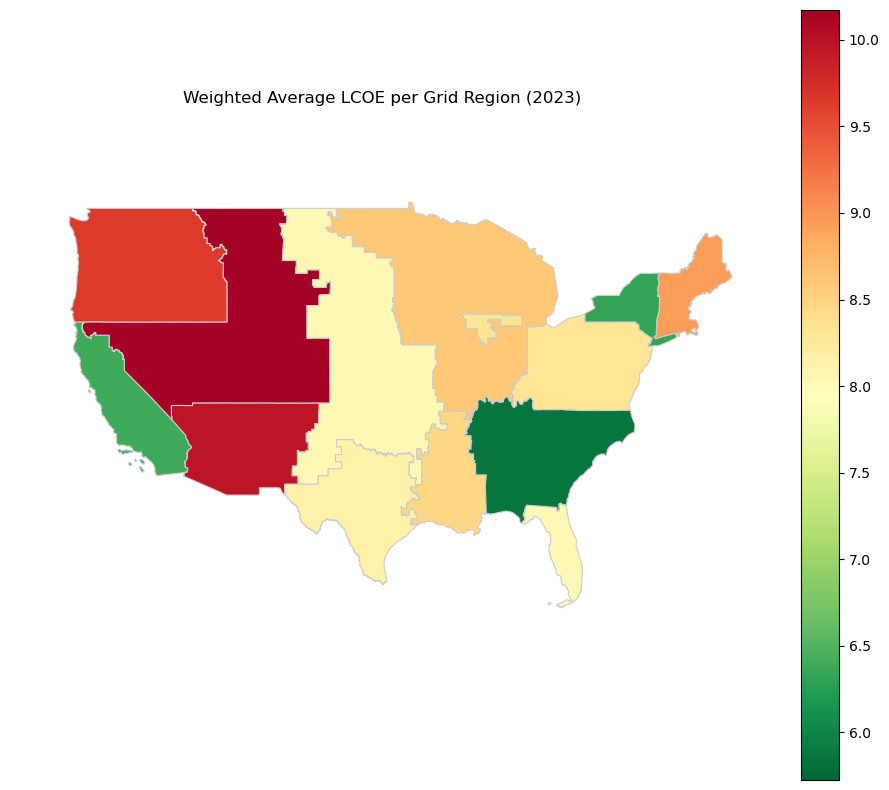

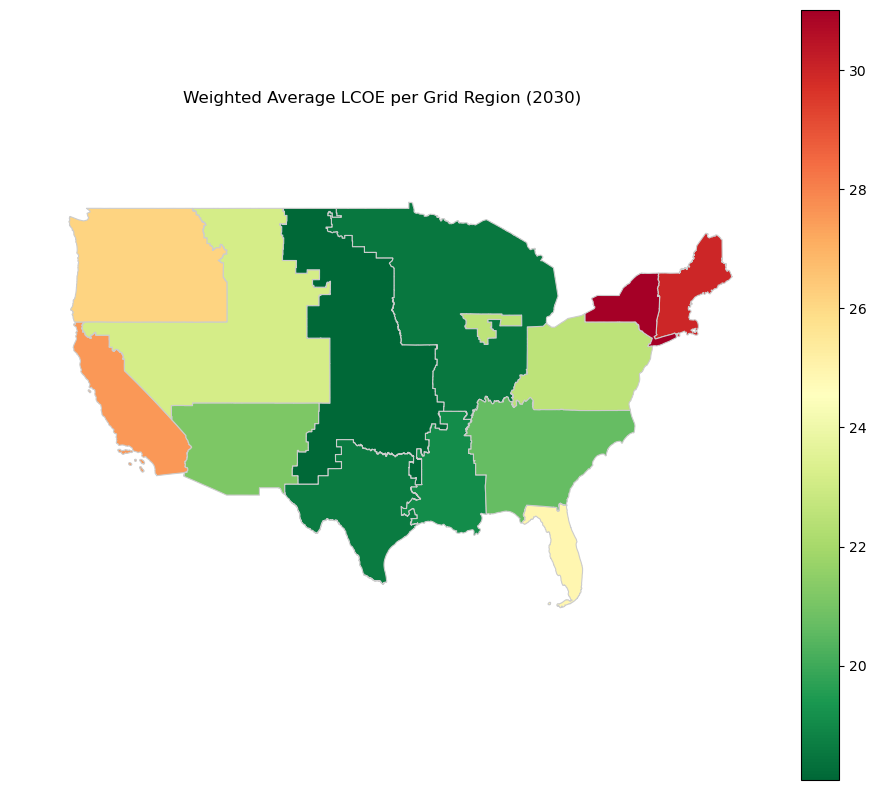

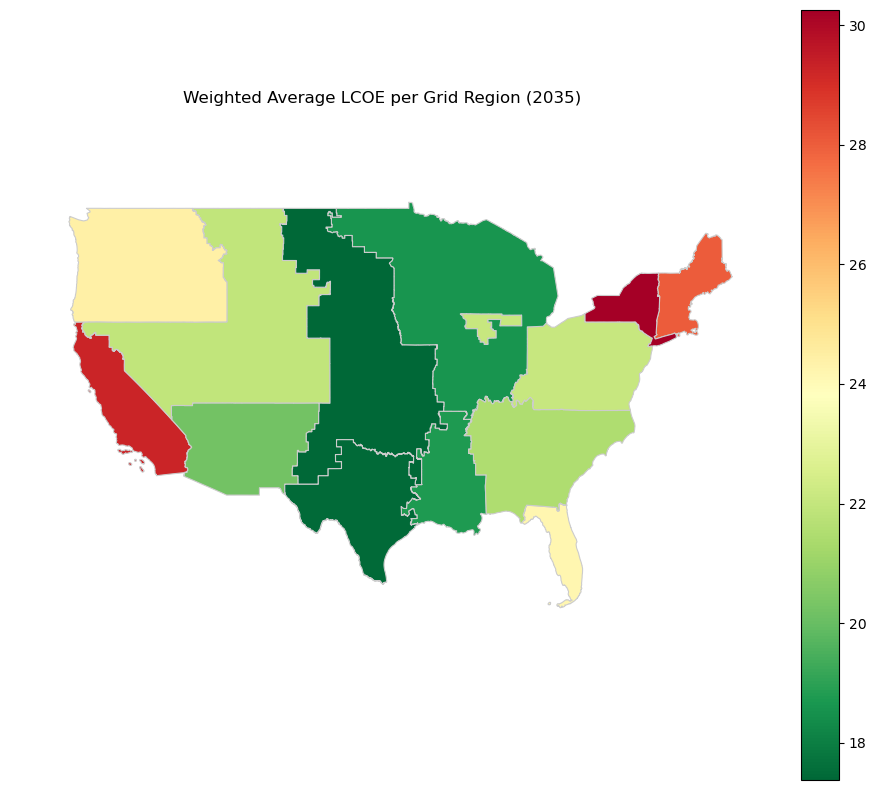

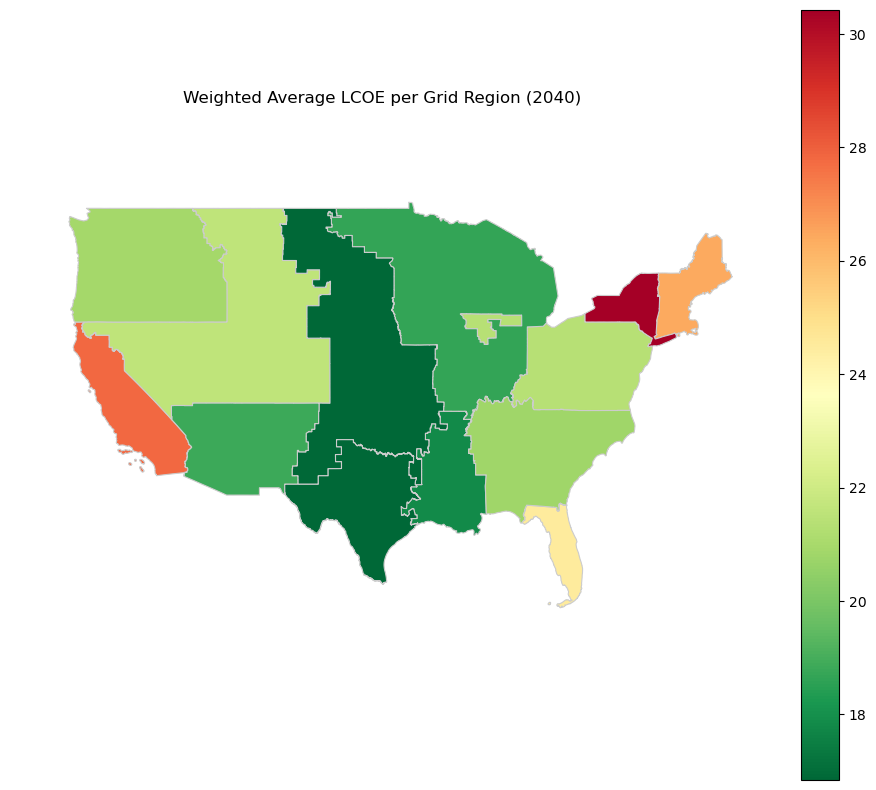

In [35]:
plots_data = {}

for key, net in networks.items():
    year_match = re.search(r'\d{4}', key)
    year_str = year_match.group() if year_match else "Year N/A"
    title = f"Weighted Average LCOE per Grid Region ({year_str})"

    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    lcoe_gdf, table, lcoe_by_bus, lcoe_data, vmin, vmax = calculate_lcoe_summary_and_map(net, shapes)
    plots_data[key] = table

    plot_lcoe_map_by_grid_region(lcoe_by_bus, lcoe_data, shapes, title=title, key=key, ax=ax)
    plt.show()


In [36]:
def uppercase_only_lcoe_word(df):
    new_cols = {
        col: re.sub(r'\blcoe\b', 'LCOE', col, flags=re.IGNORECASE)
        for col in df.columns
    }
    return df.rename(columns=new_cols)

for net_name, table in plots_data.items():
    print(f"\nTable for network: {net_name}")
    display(uppercase_only_lcoe_word(table))


Table for network: Base_2023


grid_region  CCGT LCOE [USD/MWh]  OCGT LCOE [USD/MWh]  \
0         Alaska         5.429023e+07         4.093737e+07   
1     California         5.489326e+08         3.938194e+08   
2          Delta         4.522949e+08         2.126924e+08   
3        Florida         9.948314e+08         3.559753e+08   
4         Hawaii                  NaN                  NaN   
5   Mid-Atlantic         4.850487e+08         3.035032e+08   
6        Midwest         1.716864e+08         1.680070e+08   
7       Mountain         2.349515e+08         1.366498e+08   
8    New England         6.550172e+08         9.153687e+07   
9       New York         6.650271e+08         2.522018e+08   
10     Northwest         1.462564e+08         4.037230e+07   
11        Plains         2.007451e+08         1.415902e+08   
12     Southeast         3.024912e+08         2.673892e+08   
13     Southwest         4.431886e+08         1.288982e+08   
14         Texas         5.276641e+08         2.360976e+08   

    biomass LCOE [USD/MWh]  coal LCOE [USD/MWh]  csp LCOE [USD/MWh]  \
0                     5.01         1.435112e+07         43983628.56   
1                     5.02                  NaN         28961183.89   
2                     5.04         1.273992e+09         36346271.26   
3                     5.05         2.086480e+09         29352849.65   
4                     5.01                  NaN         44015027.97   
5                     5.04         5.485717e+09         30024443.42   
6                     5.06         6.557893e+09         31372591.56   
7                     5.04         2.749507e+09         32217536.00   
8                     5.08                  NaN         28970963.44   
9                     5.02                  NaN         29103465.42   
10                    5.09         9.207937e+08         28903758.05   
11                    5.02         1.318042e+09         29837543.35   
12                    5.03         2.187841e+09         33903183.12   
13                    5.02         4.891524e+09         35071988.27   
14                    5.03         2.808920e+09         30305036.10   

    gas LCOE [USD/MWh]  geothermal LCOE [USD/MWh]  hydro LCOE [USD/MWh]  \
0                 8.83                        NaN                  0.01   
1                 8.83                20081880.37                  0.01   
2                 8.83                        NaN                  0.01   
3                 8.83                        NaN                   NaN   
4                 8.83                 1617993.92                   NaN   
5                 8.83                        NaN                  0.01   
6                 8.83                        NaN                  0.01   
7                 8.83                 3277338.17                  0.01   
8                 8.83                        NaN                  0.01   
9                 8.83                        NaN                  0.01   
10                8.83                13010416.23                  0.01   
11                8.83                 5729179.92                  0.01   
12                8.83                        NaN                  0.01   
13                8.83                 1929502.68                  0.01   
14                8.83                        NaN                  0.01   

    nuclear LCOE [USD/MWh]  oil LCOE [USD/MWh]  onwind LCOE [USD/MWh]  \
0                      NaN        8.922228e+06                  40.95   
1                    79.44        3.628957e+07                 114.21   
2                    79.44        6.159205e+07                    NaN   
3                    79.44        3.195420e+07                    NaN   
4                      NaN        6.633619e+07                  24.16   
5                    79.44        8.458601e+07                  40.74   
6                    79.44        3.192761e+07                  22.31   
7                      NaN        2.672347e+05                  28.65   
8                


Table for network: scenario_01_2030


grid_region  CCGT LCOE [USD/MWh]  OCGT LCOE [USD/MWh]  \
0         Alaska                22.34                31.60   
1     California                21.61                26.22   
2          Delta                26.56               200.05   
3        Florida                20.19                85.99   
4         Hawaii                22.72                23.89   
5   Mid-Atlantic                17.90                33.39   
6        Midwest                23.09                43.15   
7       Mountain                39.98                90.92   
8    New England                18.09                38.78   
9       New York                26.18               131.40   
10     Northwest                21.74                26.80   
11        Plains                27.99                67.11   
12     Southeast                18.60                31.18   
13     Southwest                26.13                74.71   
14         Texas                29.95               130.26   

    biomass LCOE [USD/MWh]  coal LCOE [USD/MWh]  csp LCOE [USD/MWh]  \
0                    64.28                  NaN              285.57   
1                    65.32                  NaN              135.85   
2                    67.68                14.70              238.76   
3                    68.27                14.58              162.73   
4                    64.28                  NaN              210.68   
5                    64.91                13.95              216.51   
6                    66.45                16.04              220.43   
7                    65.72                20.03              138.57   
8                    67.03                  NaN              436.42   
9                    64.28                  NaN              232.17   
10                   69.03                16.80              169.88   
11                   65.78                18.05              156.69   
12                   71.02                14.76              208.65   
13                   64.98                16.60              137.22   
14                   65.06                17.12              161.15   

    gas LCOE [USD/MWh]  geothermal LCOE [USD/MWh]  hydro LCOE [USD/MWh]  \
0                16.21                        NaN                  0.01   
1                16.21                      59.67                  0.01   
2                16.21                        NaN                  0.01   
3                16.21                        NaN                   NaN   
4                16.21                      68.05                   NaN   
5                16.21                        NaN                  0.01   
6                16.21                        NaN                  0.01   
7                16.21                      60.66                  0.01   
8                16.21                        NaN                  0.01   
9                16.21                        NaN                  0.01   
10               16.21                      60.34                  0.01   
11               16.21                      67.70                  0.01   
12               16.21                        NaN                  0.01   
13               16.21                      62.63                  0.01   
14               16.21                        NaN                  0.01   

    nuclear LCOE [USD/MWh]  offwind-dc LCOE [USD/MWh]  oil LCOE [USD/MWh]  \
0                      NaN                     264.49                8.27   
1                   149.74                     180.34               51.02   
2                   146.98                     281.82                7.85   
3                   128.70                     278.33               51.01   
4                      NaN                     162.09                9.18   
5                    99.05                     155.88               50.96   
6                   133.40                        NaN               42.91   
7                      NaN                     134.73     


Table for network: scenario_01_2035


grid_region  CCGT LCOE [USD/MWh]  OCGT LCOE [USD/MWh]  \
0         Alaska                22.63                20.79   
1     California                53.53               631.02   
2          Delta                26.37                57.18   
3        Florida                20.76                43.96   
4         Hawaii                22.29                20.60   
5   Mid-Atlantic                19.35                29.28   
6        Midwest                24.76                34.17   
7       Mountain                37.31                69.42   
8    New England                18.85                27.29   
9       New York                24.71                76.91   
10     Northwest                22.51                17.07   
11        Plains                30.43                42.22   
12     Southeast                20.38                31.87   
13     Southwest                23.66                26.73   
14         Texas                31.07                58.02   

    biomass LCOE [USD/MWh]  coal LCOE [USD/MWh]  csp LCOE [USD/MWh]  \
0                    64.29                  NaN              471.91   
1                    65.32                  NaN              184.16   
2                    67.66                15.67              266.94   
3                    68.26                15.39              267.12   
4                    64.28                  NaN              221.23   
5                    64.91                14.12              325.15   
6                    65.47                16.74              309.99   
7                    65.72                20.63              221.84   
8                    66.99                  NaN              429.02   
9                    64.29                  NaN              396.47   
10                   68.57                18.02              250.75   
11                   65.77                19.21              249.98   
12                   70.98                15.44              310.53   
13                   64.98                17.71              193.61   
14                   65.06                18.33              238.81   

    gas LCOE [USD/MWh]  geothermal LCOE [USD/MWh]  hydro LCOE [USD/MWh]  \
0                16.21                        NaN                  0.01   
1                16.21                      64.58                  0.01   
2                16.21                        NaN                  0.01   
3                16.21                        NaN                   NaN   
4                16.21                      70.54                   NaN   
5                16.21                        NaN                  0.01   
6                16.21                        NaN                  0.01   
7                16.21                      65.21                  0.01   
8                16.21                        NaN                  0.01   
9                16.21                        NaN                  0.01   
10               16.21                      65.84                  0.01   
11               16.21                      71.07                  0.01   
12               16.21                        NaN                  0.01   
13               16.21                      66.49                  0.01   
14               16.21                        NaN                  0.01   

    nuclear LCOE [USD/MWh]  offwind-dc LCOE [USD/MWh]  oil LCOE [USD/MWh]  \
0                      NaN                     196.76                8.60   
1                   148.78                     165.32               51.01   
2                   158.33                     238.95                8.20   
3                   156.87                     248.51               50.99   
4                      NaN                     150.89                 NaN   
5                   155.22                     139.88               51.00   
6                   159.35                        NaN               42.10   
7                      NaN                     129.49     


Table for network: scenario_01_2040


grid_region  CCGT LCOE [USD/MWh]  OCGT LCOE [USD/MWh]  \
0         Alaska         2.097000e+01         1.872000e+01   
1     California         6.648000e+01         1.290100e+02   
2          Delta         2.207000e+01         2.848000e+01   
3        Florida         2.003000e+01         2.699000e+01   
4         Hawaii         2.257000e+01         2.119000e+01   
5   Mid-Atlantic         1.940000e+01         2.886000e+01   
6        Midwest         2.792000e+01         3.089000e+01   
7       Mountain         3.660000e+01         4.011000e+01   
8    New England         1.954000e+01         2.887000e+01   
9       New York         3.470013e+11         2.375772e+10   
10     Northwest         2.701000e+01         2.016000e+01   
11        Plains         2.699000e+01         3.242000e+01   
12     Southeast         1.968000e+01         2.755000e+01   
13     Southwest         2.193000e+01         2.066000e+01   
14         Texas         2.613000e+01         3.031000e+01   

    biomass LCOE [USD/MWh]  coal LCOE [USD/MWh]  csp LCOE [USD/MWh]  \
0                    64.30                  NaN               86.02   
1                    64.88                  NaN               58.79   
2                    64.29                16.10               60.76   
3                    68.19                  NaN               59.07   
4                    64.28                  NaN               60.80   
5                    64.90                14.18               62.38   
6                    65.46                16.78               66.39   
7                    65.70                32.48               64.24   
8                    66.96                  NaN              654.92   
9                    64.29                  NaN               69.12   
10                   64.76                17.96               63.79   
11                   65.67                19.56               66.84   
12                   70.00                15.82               61.38   
13                   64.29                18.45               60.30   
14                   65.05                18.81               65.18   

    gas LCOE [USD/MWh]  geothermal LCOE [USD/MWh]  hydro LCOE [USD/MWh]  \
0                16.21                        NaN                  0.01   
1                16.21                      66.02                  0.01   
2                16.21                        NaN                  0.01   
3                16.21                        NaN                   NaN   
4                16.21                      69.77                   NaN   
5                16.21                        NaN                  0.01   
6                16.21                        NaN                  0.01   
7                16.21                      67.38                  0.01   
8                16.21                        NaN                  0.01   
9                16.21                        NaN                  0.01   
10               16.21                      65.92                  0.01   
11               16.21                      75.67                  0.01   
12               16.21                        NaN                  0.01   
13               16.21                      70.24                  0.01   
14               16.21                        NaN                  0.01   

    nuclear LCOE [USD/MWh]  offwind-dc LCOE [USD/MWh]  oil LCOE [USD/MWh]  \
0                      NaN                     185.22                 NaN   
1                   131.11                     133.39               51.00   
2                   124.04                     171.78                 NaN   
3                   120.33                     175.49               50.99   
4                      NaN                     123.37                 NaN   
5                   122.39                     104.18               50.96   
6                   133.15                        NaN               11.31   
7                      NaN                     105.30     

### 6.2. Map: Levelized Cost of Hydrogen (LCOH)
*A map displaying the LCOH according to the grid region.*

In [37]:
h2_carriers = [
    "Alkaline electrolyzer large",
    "Alkaline electrolyzer medium",
    "Alkaline electrolyzer small",
    "PEM electrolyzer",
    "SOEC"
]

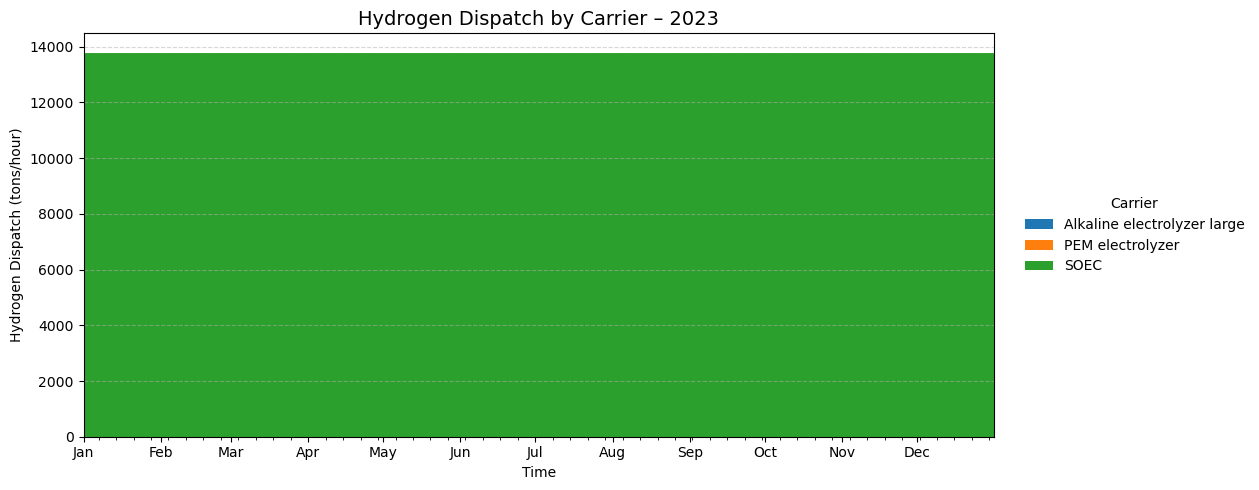

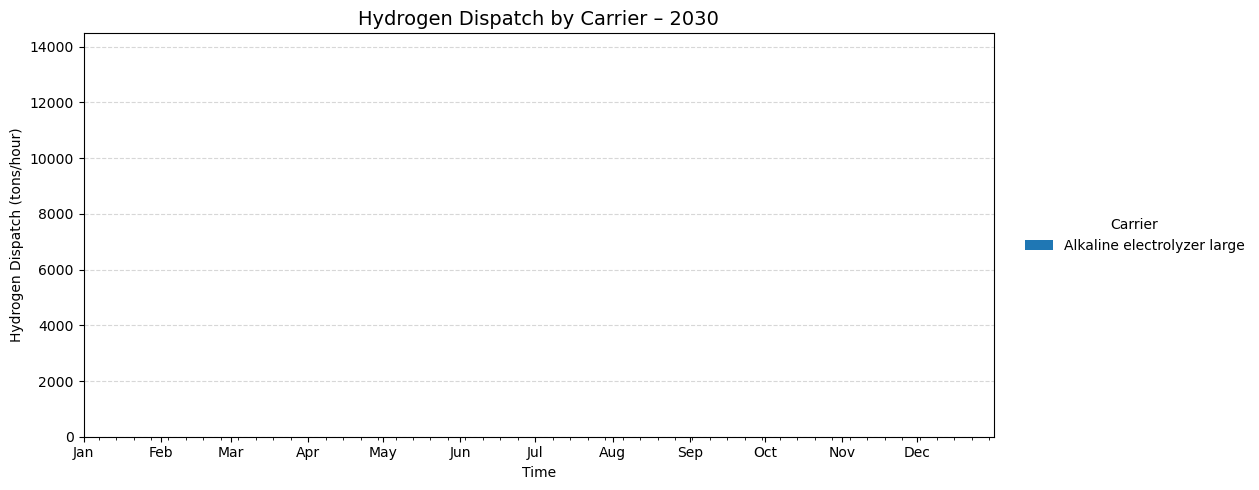

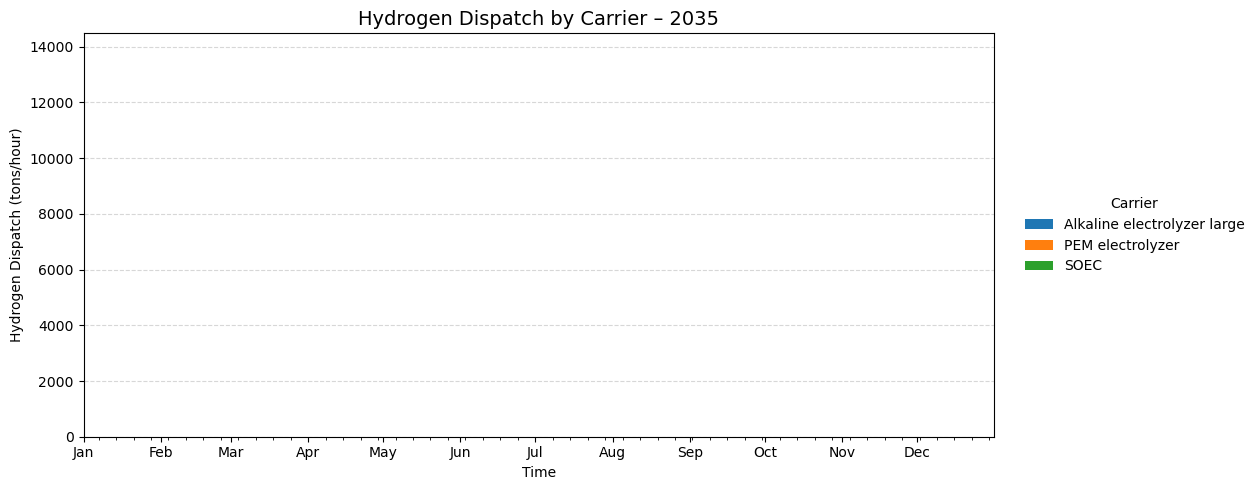

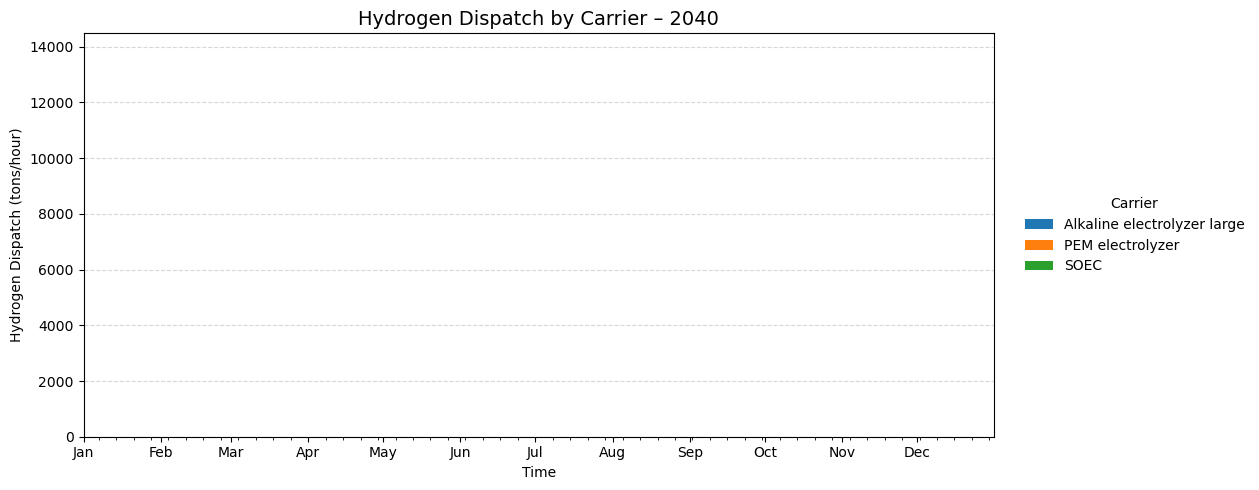

In [38]:
plot_hourly_hydrogen_dispatch_all(networks, h2_carriers)


Processing year: Base_2023
Processing year: scenario_01_2030
  No links with H2 output > 100 MWh, skipping.
Processing year: scenario_01_2035
  No links with H2 output > 100 MWh, skipping.
Processing year: scenario_01_2040
  No links with H2 output > 100 MWh, skipping.


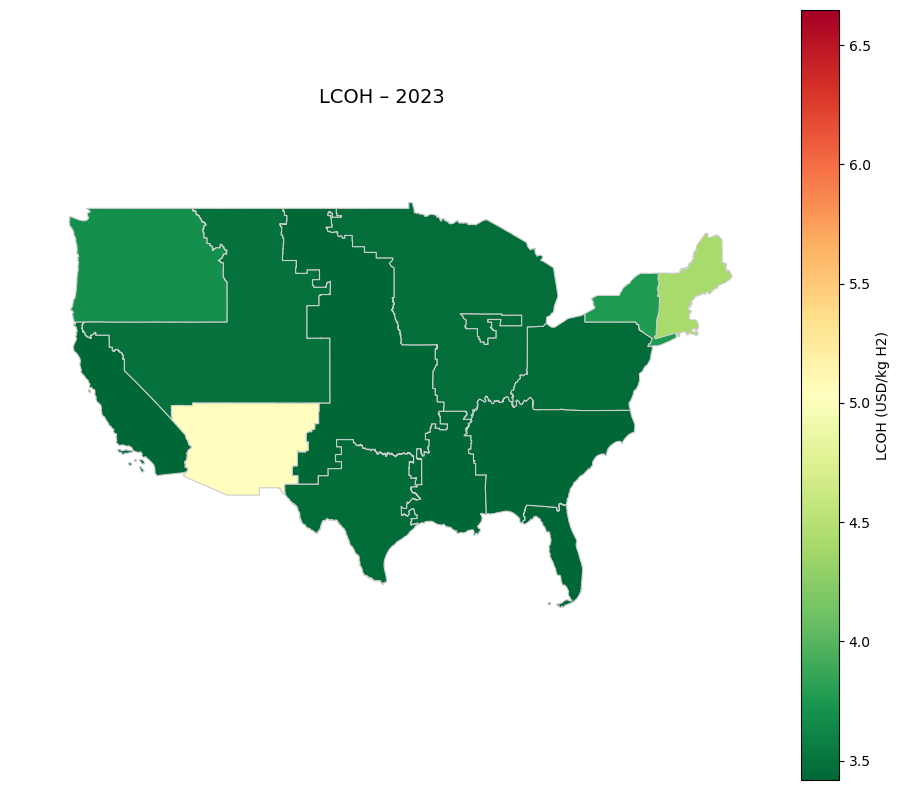

In [39]:
plot_lcoh_maps_by_grid_region(networks, shapes, h2_carriers, output_threshold=100) # Threshdld in MWh/year

In [40]:
tables_by_year = calculate_weighted_lcoh_table_by_year(networks, h2_carriers, output_threshold=100) # Threshdld in MWh/year

pd.options.display.float_format = '{:,.2f}'.format

for year, table in tables_by_year.items():
    print(f"--- LCOH summary for year {year} ---")
    display(table)

--- LCOH summary for year 2023 ---


grid_region  Weighted Average LCOH (USD/kg)  \
0         Alaska                            8.92   
1     California                            3.42   
2          Delta                            3.42   
3        Florida                            3.42   
4         Hawaii                            5.67   
5   Mid-Atlantic                            3.45   
6        Midwest                            3.46   
7       Mountain                            3.49   
8    New England                            4.40   
9       New York                            3.77   
10     Northwest                            3.69   
11        Plains                            3.43   
12     Southeast                            3.42   
13     Southwest                            5.04   
14         Texas                            3.45   

    Total Hydrogen Dispatch (tons)  
0                            50.71  
1                     2,871,611.91  
2                       394,457.01  
3                       459,585.32  
4                           123.85  
5                        86,929.30  
6                       131,856.17  
7                        26,488.41  
8                           848.90  
9                         2,382.00  
10                        7,312.31  
11                      360,299.70  
12                   35,860,035.82  
13                        1,031.94  
14                       70,229.64

---

## 7. Sector-Specific Analysis: E-Kerosene Deep Dive

*A dedicated section to analyze the production chain, costs, and outputs related to synthetic aviation fuel.*

### 7.1. E-Kerosene Production and Costs
*Analysis of the Fischer-Tropsch process, including inputs (H2, CO2), outputs (e-kerosene), and the resulting levelized cost of the fuel.*

In [41]:
# Code to analyze the FT links, their inputs/outputs,
# and calculate the Levelized Cost of Kerosene (LCOK).
pass

---